In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300

In [2]:
df = pd.read_csv('./kospi.csv')
df.set_index('Date', inplace=True)
df.shape

(4657, 6)

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2003-01-02,637.099976,623.750000,633.030029,635.169983,742900.0,635.169983
2003-01-03,662.400024,649.619995,651.590027,661.099976,1005800.0,661.099976
2003-01-06,667.710022,657.609985,665.099976,666.710022,721800.0,666.710022
2003-01-07,679.299988,652.140015,679.000000,652.200012,690100.0,652.200012
2003-01-08,660.390015,650.929993,655.969971,651.719971,604900.0,651.719971


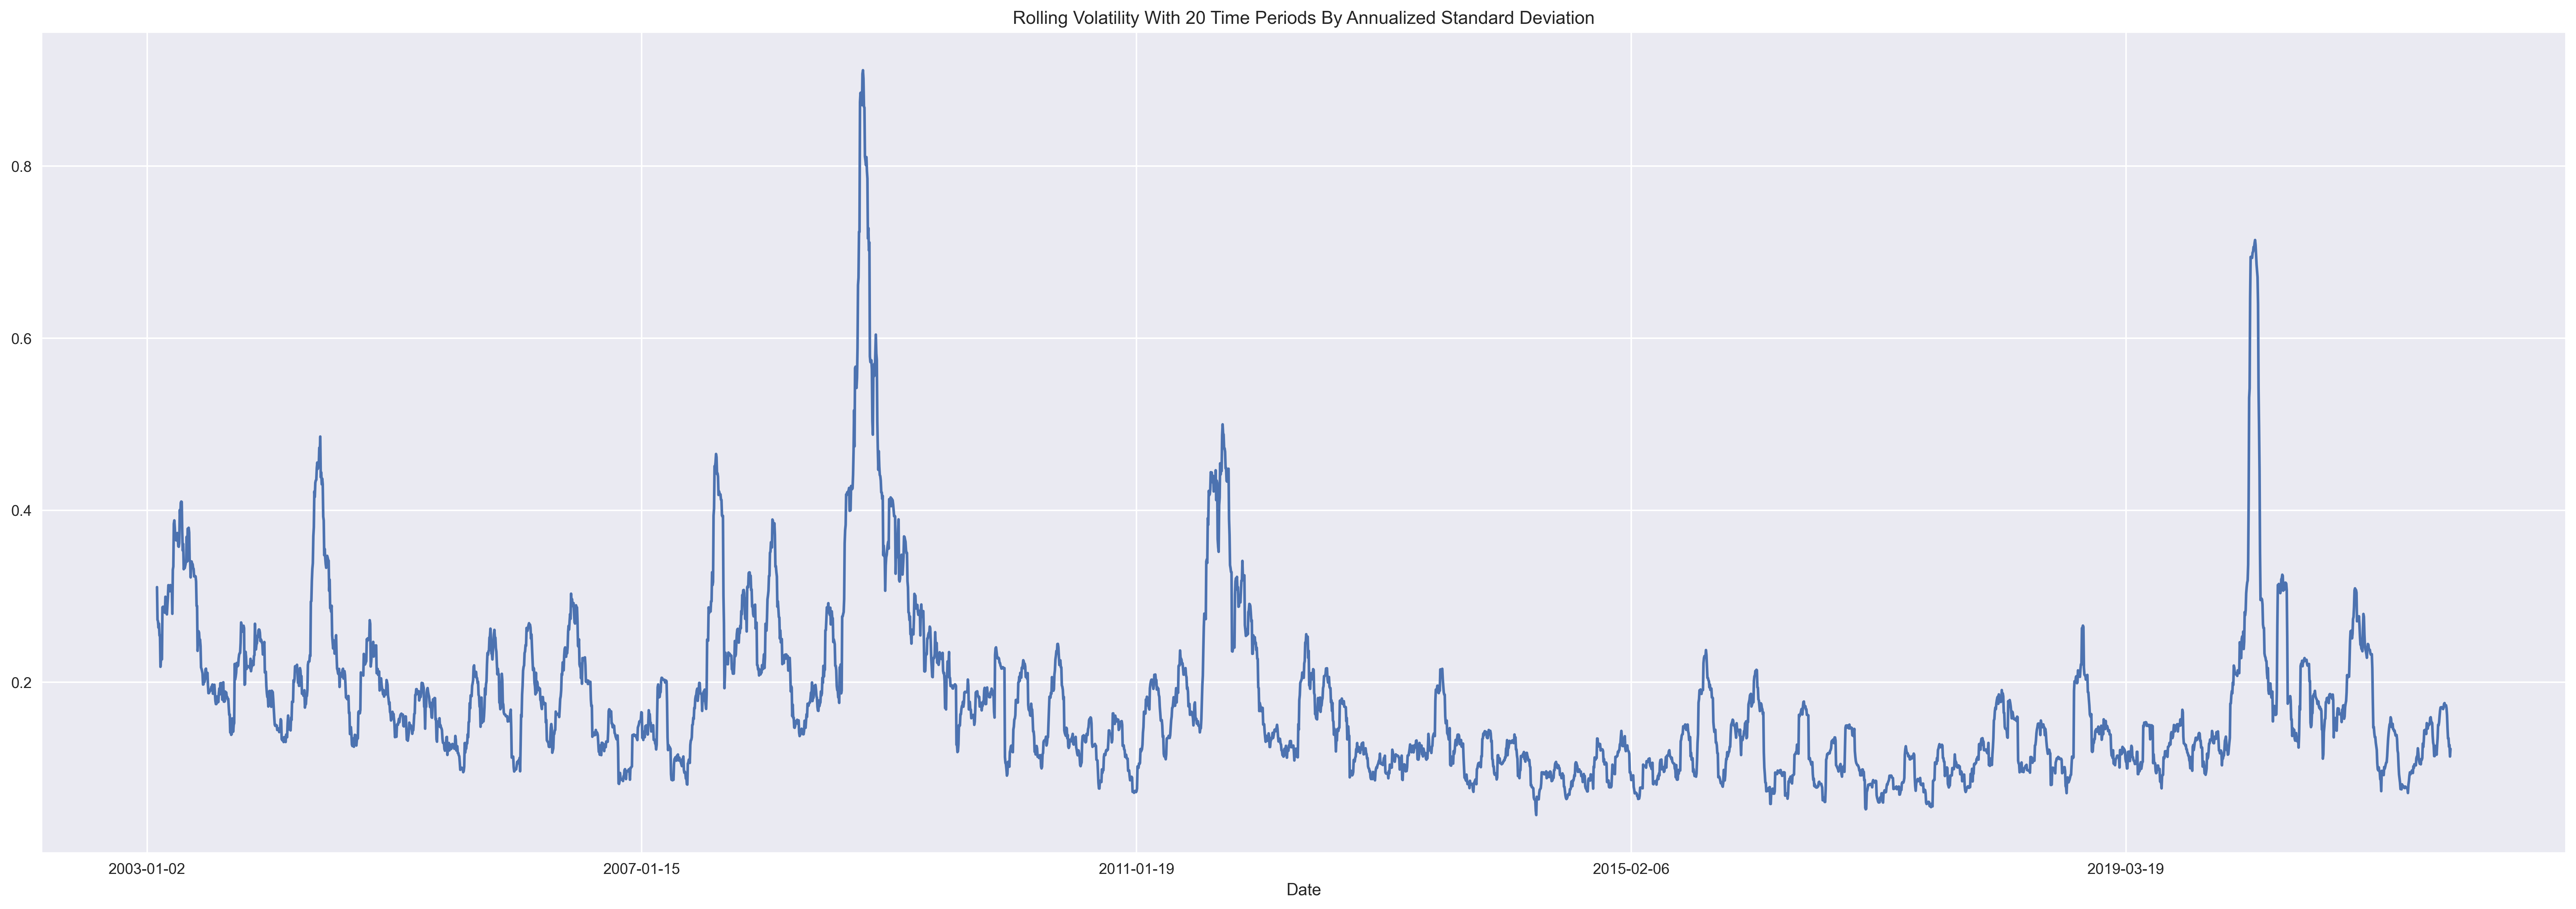

In [4]:
df['Change']    = df['Close'].pct_change()
df['STDEV']     = df['Close'].rolling(window=20).std(ddof=0)
df['STDEV_log'] = np.log(df['Close'].rolling(window=20).std(ddof=0))
df['HV']        = df['Change'].rolling(window=20, center=False).std() * (252 ** 0.5)

df['HV'].plot(figsize=(30, 10))
plt.title('Rolling Volatility With 20 Time Periods By Annualized Standard Deviation')
plt.show()

In [5]:
df = df.loc['2003-09-29':'2021-09-28', 'STDEV':'HV']
print(df.shape)
df.head()

(4444, 3)


,STDEV,STDEV_log,HV
Date,,,
2003-09-29,24.124472,3.183227,0.218297
2003-09-30,26.250174,3.267673,0.218889
2003-10-01,27.269902,3.305784,0.219563
2003-10-02,27.224549,3.304119,0.227551
2003-10-06,26.583629,3.280296,0.232149


In [6]:
array = df.values
window_size = 20

X_std     = []
X_std_log = []
X_hv      = []

y_std     = []
y_std_log = []
y_hv      = []

for i in range(df.shape[0] - window_size):
    X_std.append(array[i:i + window_size, 0])
    X_std_log.append(array[i:i + window_size, 1])
    X_hv.append(array[i:i + window_size, 2])
    y_std.append(array[i + window_size, 0])
    y_std_log.append(array[i + window_size, 1])
    y_hv.append(array[i + window_size, 2])

In [7]:
X = []
for i in [X_std, X_std_log, X_hv]:
    X.append(np.array(i))

y = []
for i in [y_std, y_std_log, y_hv]:
    y.append(np.array(i))

for i, j in zip(X, y):
    print(i.shape, j.shape)

(4424, 20) (4424,)
(4424, 20) (4424,)
(4424, 20) (4424,)


In [8]:
test_size = df.loc['2020-09-29':].shape[0] - window_size
test_size

225

In [9]:
df[:-20].iloc[-test_size:]

,STDEV,STDEV_log,HV
Date,,,
2020-09-29,47.945960,3.870075,0.185499
2020-10-05,48.020769,3.871634,0.190111
2020-10-06,47.727691,3.865512,0.183980
2020-10-07,47.851505,3.868103,0.182101
2020-10-08,47.982069,3.870827,0.180716
...,...,...,...
2021-08-20,57.270309,4.047782,0.124768
2021-08-23,62.195515,4.130283,0.131948
2021-08-24,63.590489,4.152464,0.144221


In [10]:
df[:-20].iloc[:-test_size]

,STDEV,STDEV_log,HV
Date,,,
2003-09-29,24.124472,3.183227,0.218297
2003-09-30,26.250174,3.267673,0.218889
2003-10-01,27.269902,3.305784,0.219563
2003-10-02,27.224549,3.304119,0.227551
2003-10-06,26.583629,3.280296,0.232149
...,...,...,...
2020-09-22,32.283788,3.474565,0.164295
2020-09-23,34.001746,3.526412,0.164204
2020-09-24,40.861261,3.710182,0.184335


In [11]:
X_train = []
y_train = []
X_test  = []
y_test  = []
for i, j in zip(X, y):
    X_train.append(np.expand_dims(i[:-test_size], axis=-1))
    y_train.append(np.expand_dims(j[:-test_size], axis=-1))
    X_test.append(np.expand_dims(i[-test_size:], axis=-1))
    y_test.append(np.expand_dims(j[-test_size:], axis=-1))

In [12]:
X_train[0].shape, y_train[0].shape, X_test[0].shape, y_test[0].shape

((4199, 20, 1), (4199, 1), (225, 20, 1), (225, 1))

In [13]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional

histories = []
models    = []
for i, j, k, l in zip(X_train, y_train, X_test, y_test):
    
    input  = Input(batch_shape=(None, X_train[0].shape[1], X_train[0].shape[2]))
    lstm1  = LSTM(units=10, return_sequences=True)(input)
    lstm2  = Bidirectional(LSTM(units=10))(lstm1)
    output = Dense(units=1)(lstm2)
    
    model = Model(input, output)
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(i, j, validation_data=(k, l), epochs=5, batch_size=20, verbose=1)
    models.append(model)
    histories.append(history)

Epoch 1/5
210/210 [==============================] - 8s 17ms/step - loss: 1194.4800 - val_loss: 2679.6418
Epoch 2/5
210/210 [==============================] - 2s 11ms/step - loss: 846.1716 - val_loss: 2275.3958
Epoch 3/5
210/210 [==============================] - 2s 11ms/step - loss: 687.6055 - val_loss: 2002.5602
Epoch 4/5
210/210 [==============================] - 2s 12ms/step - loss: 586.3743 - val_loss: 1796.1565
Epoch 5/5
210/210 [==============================] - 2s 11ms/step - loss: 519.9635 - val_loss: 1637.5172
Epoch 1/5
210/210 [==============================] - 10s 19ms/step - loss: 1.4947 - val_loss: 0.4709
Epoch 2/5
210/210 [==============================] - 2s 11ms/step - loss: 0.1917 - val_loss: 0.1537
Epoch 3/5
210/210 [==============================] - 2s 11ms/step - loss: 0.0773 - val_loss: 0.0521
Epoch 4/5
210/210 [==============================] - 2s 12ms/step - loss: 0.0494 - val_loss: 0.0423
Epoch 5/5
210/210 [==============================] - 2s 11ms/step - loss:

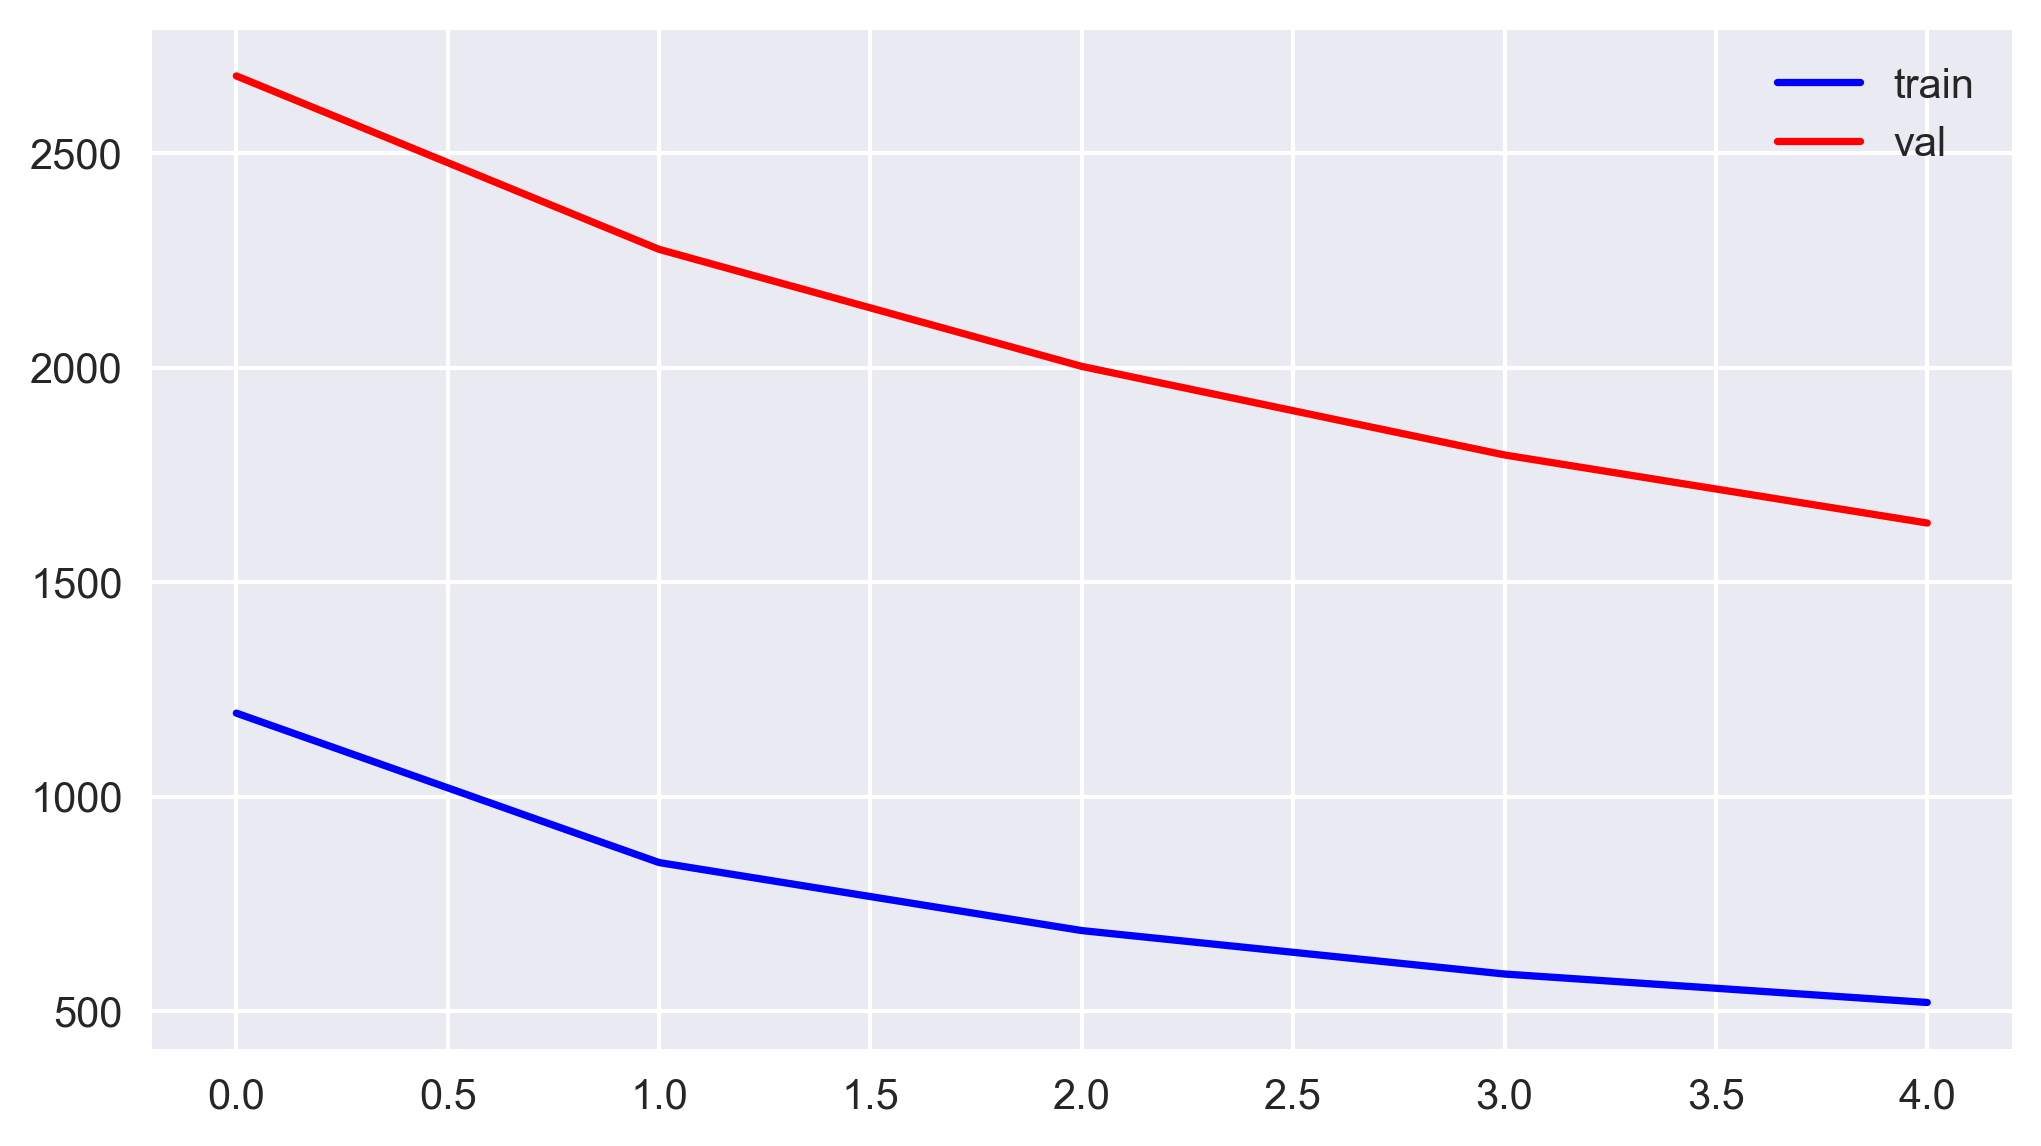

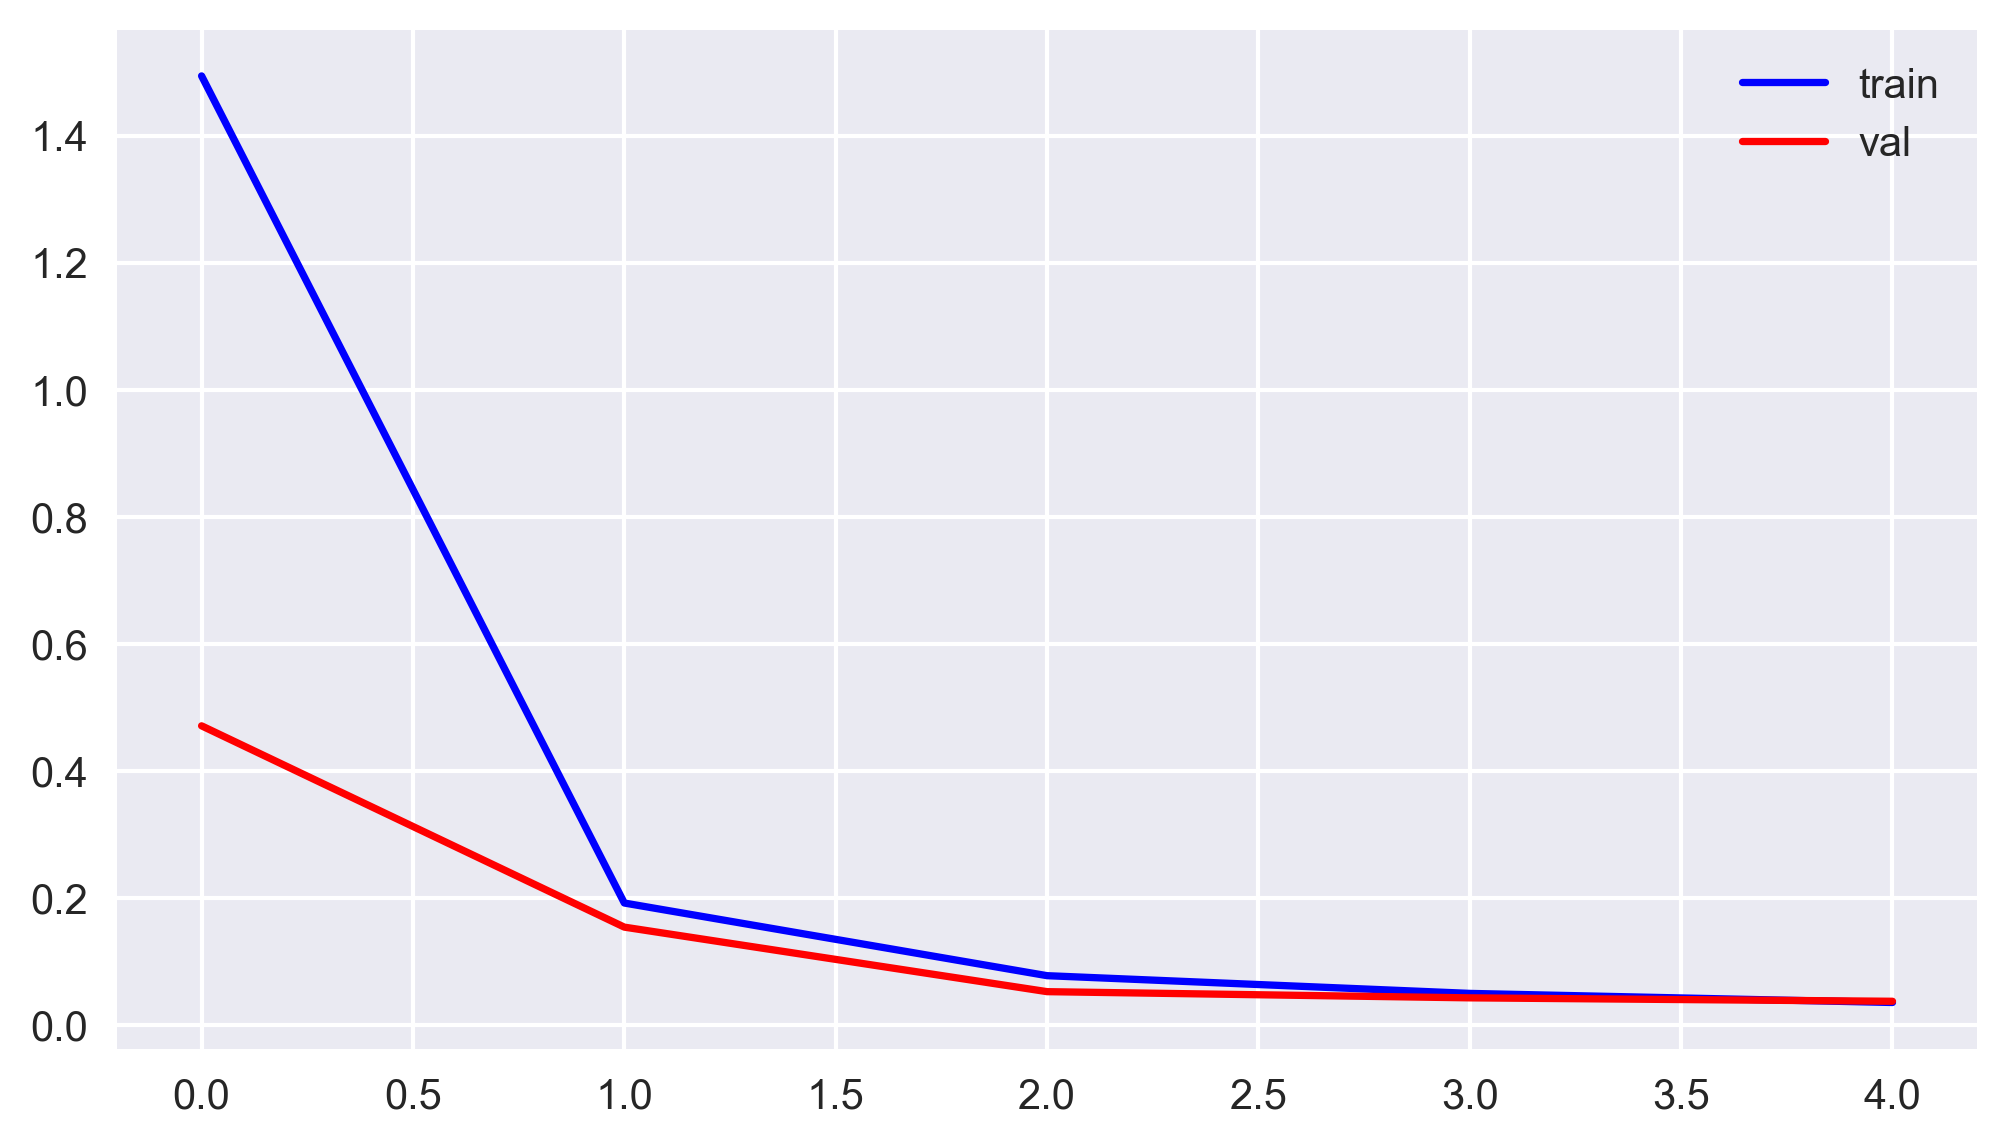

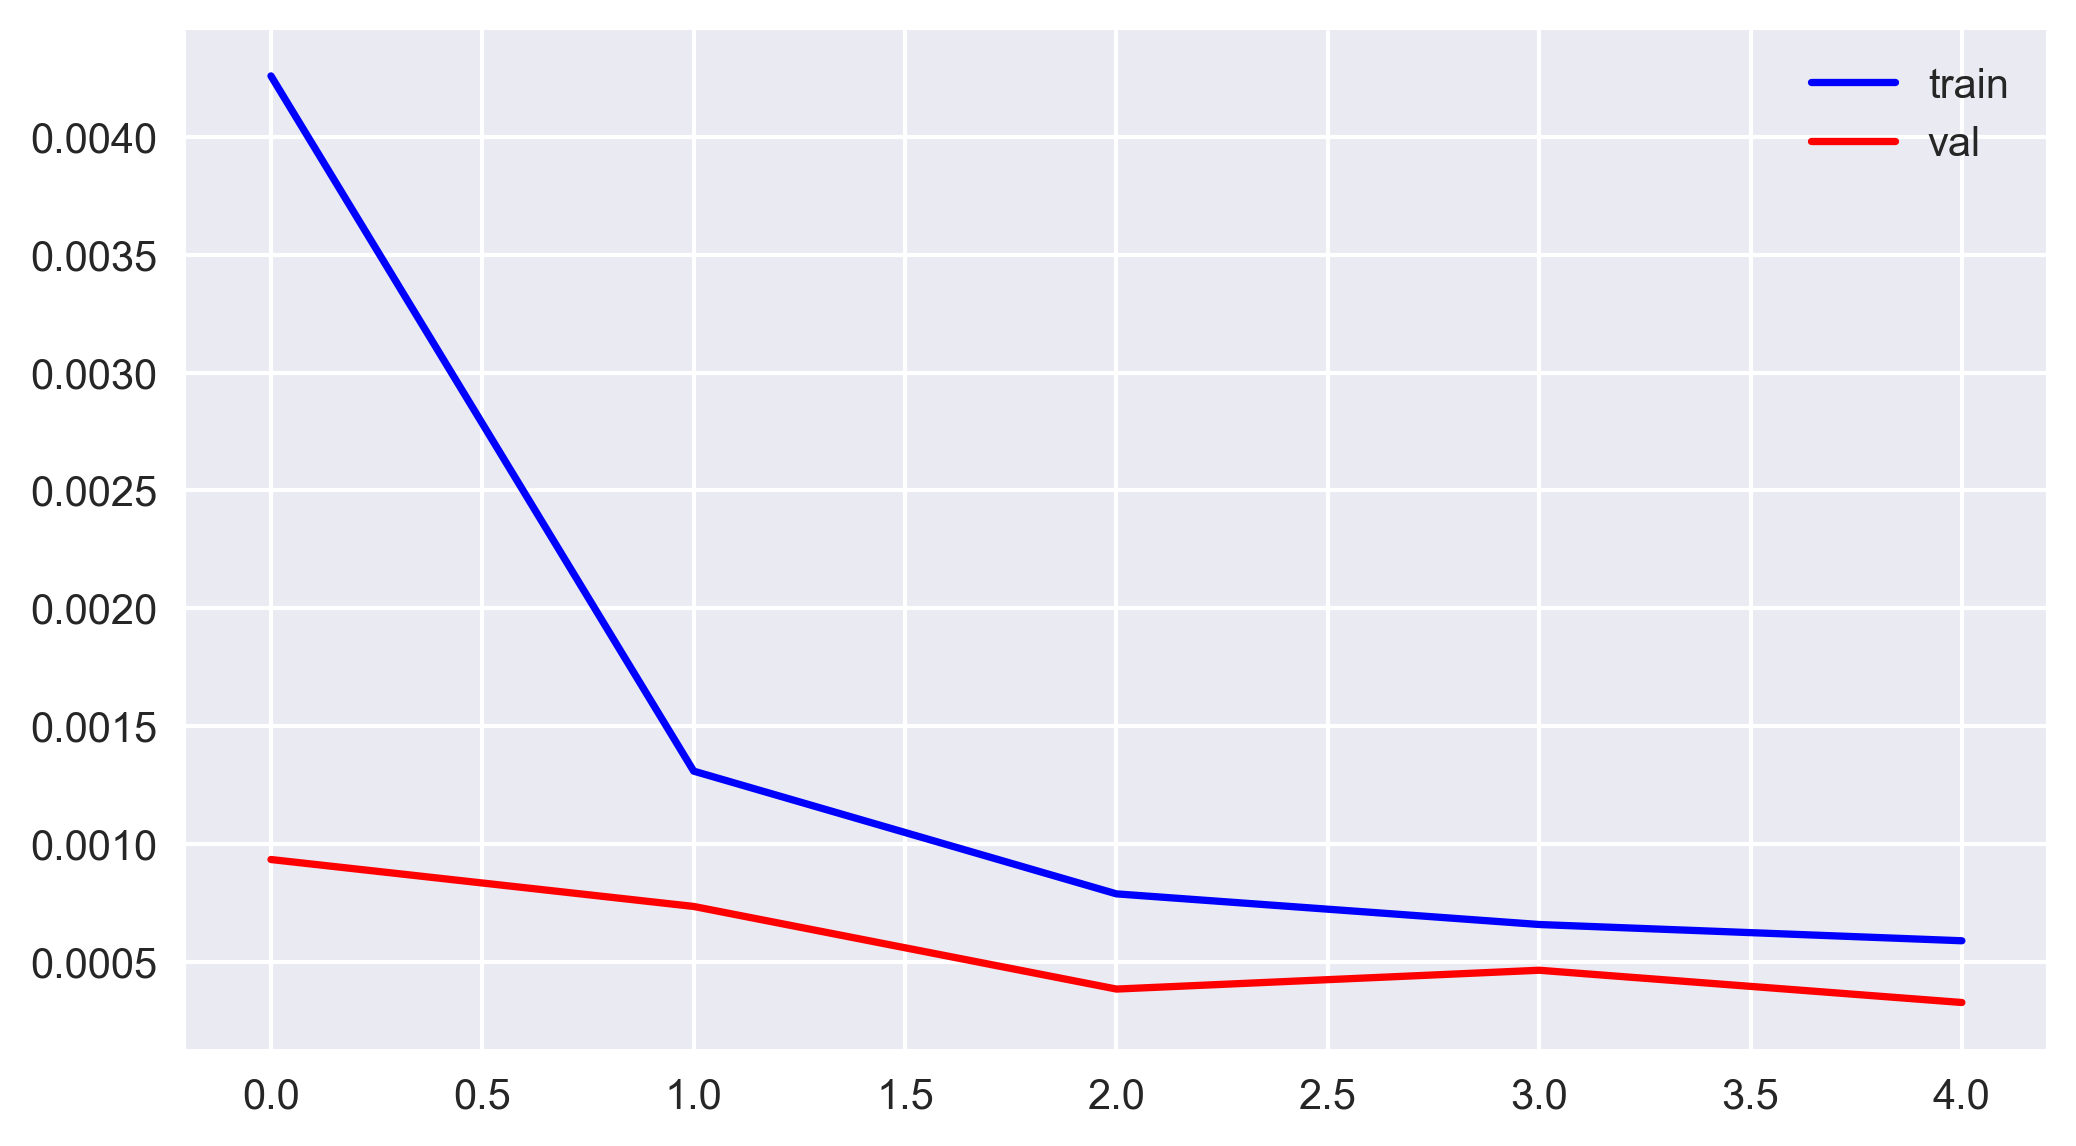

In [14]:
for h in histories:
    train_loss = h.history['loss']
    val_loss   = h.history['val_loss']
    plt.plot(range(len(train_loss)), train_loss, c='b', label='train')
    plt.plot(range(len(val_loss)), val_loss, c='r', label='val')
    plt.legend()
    plt.show()

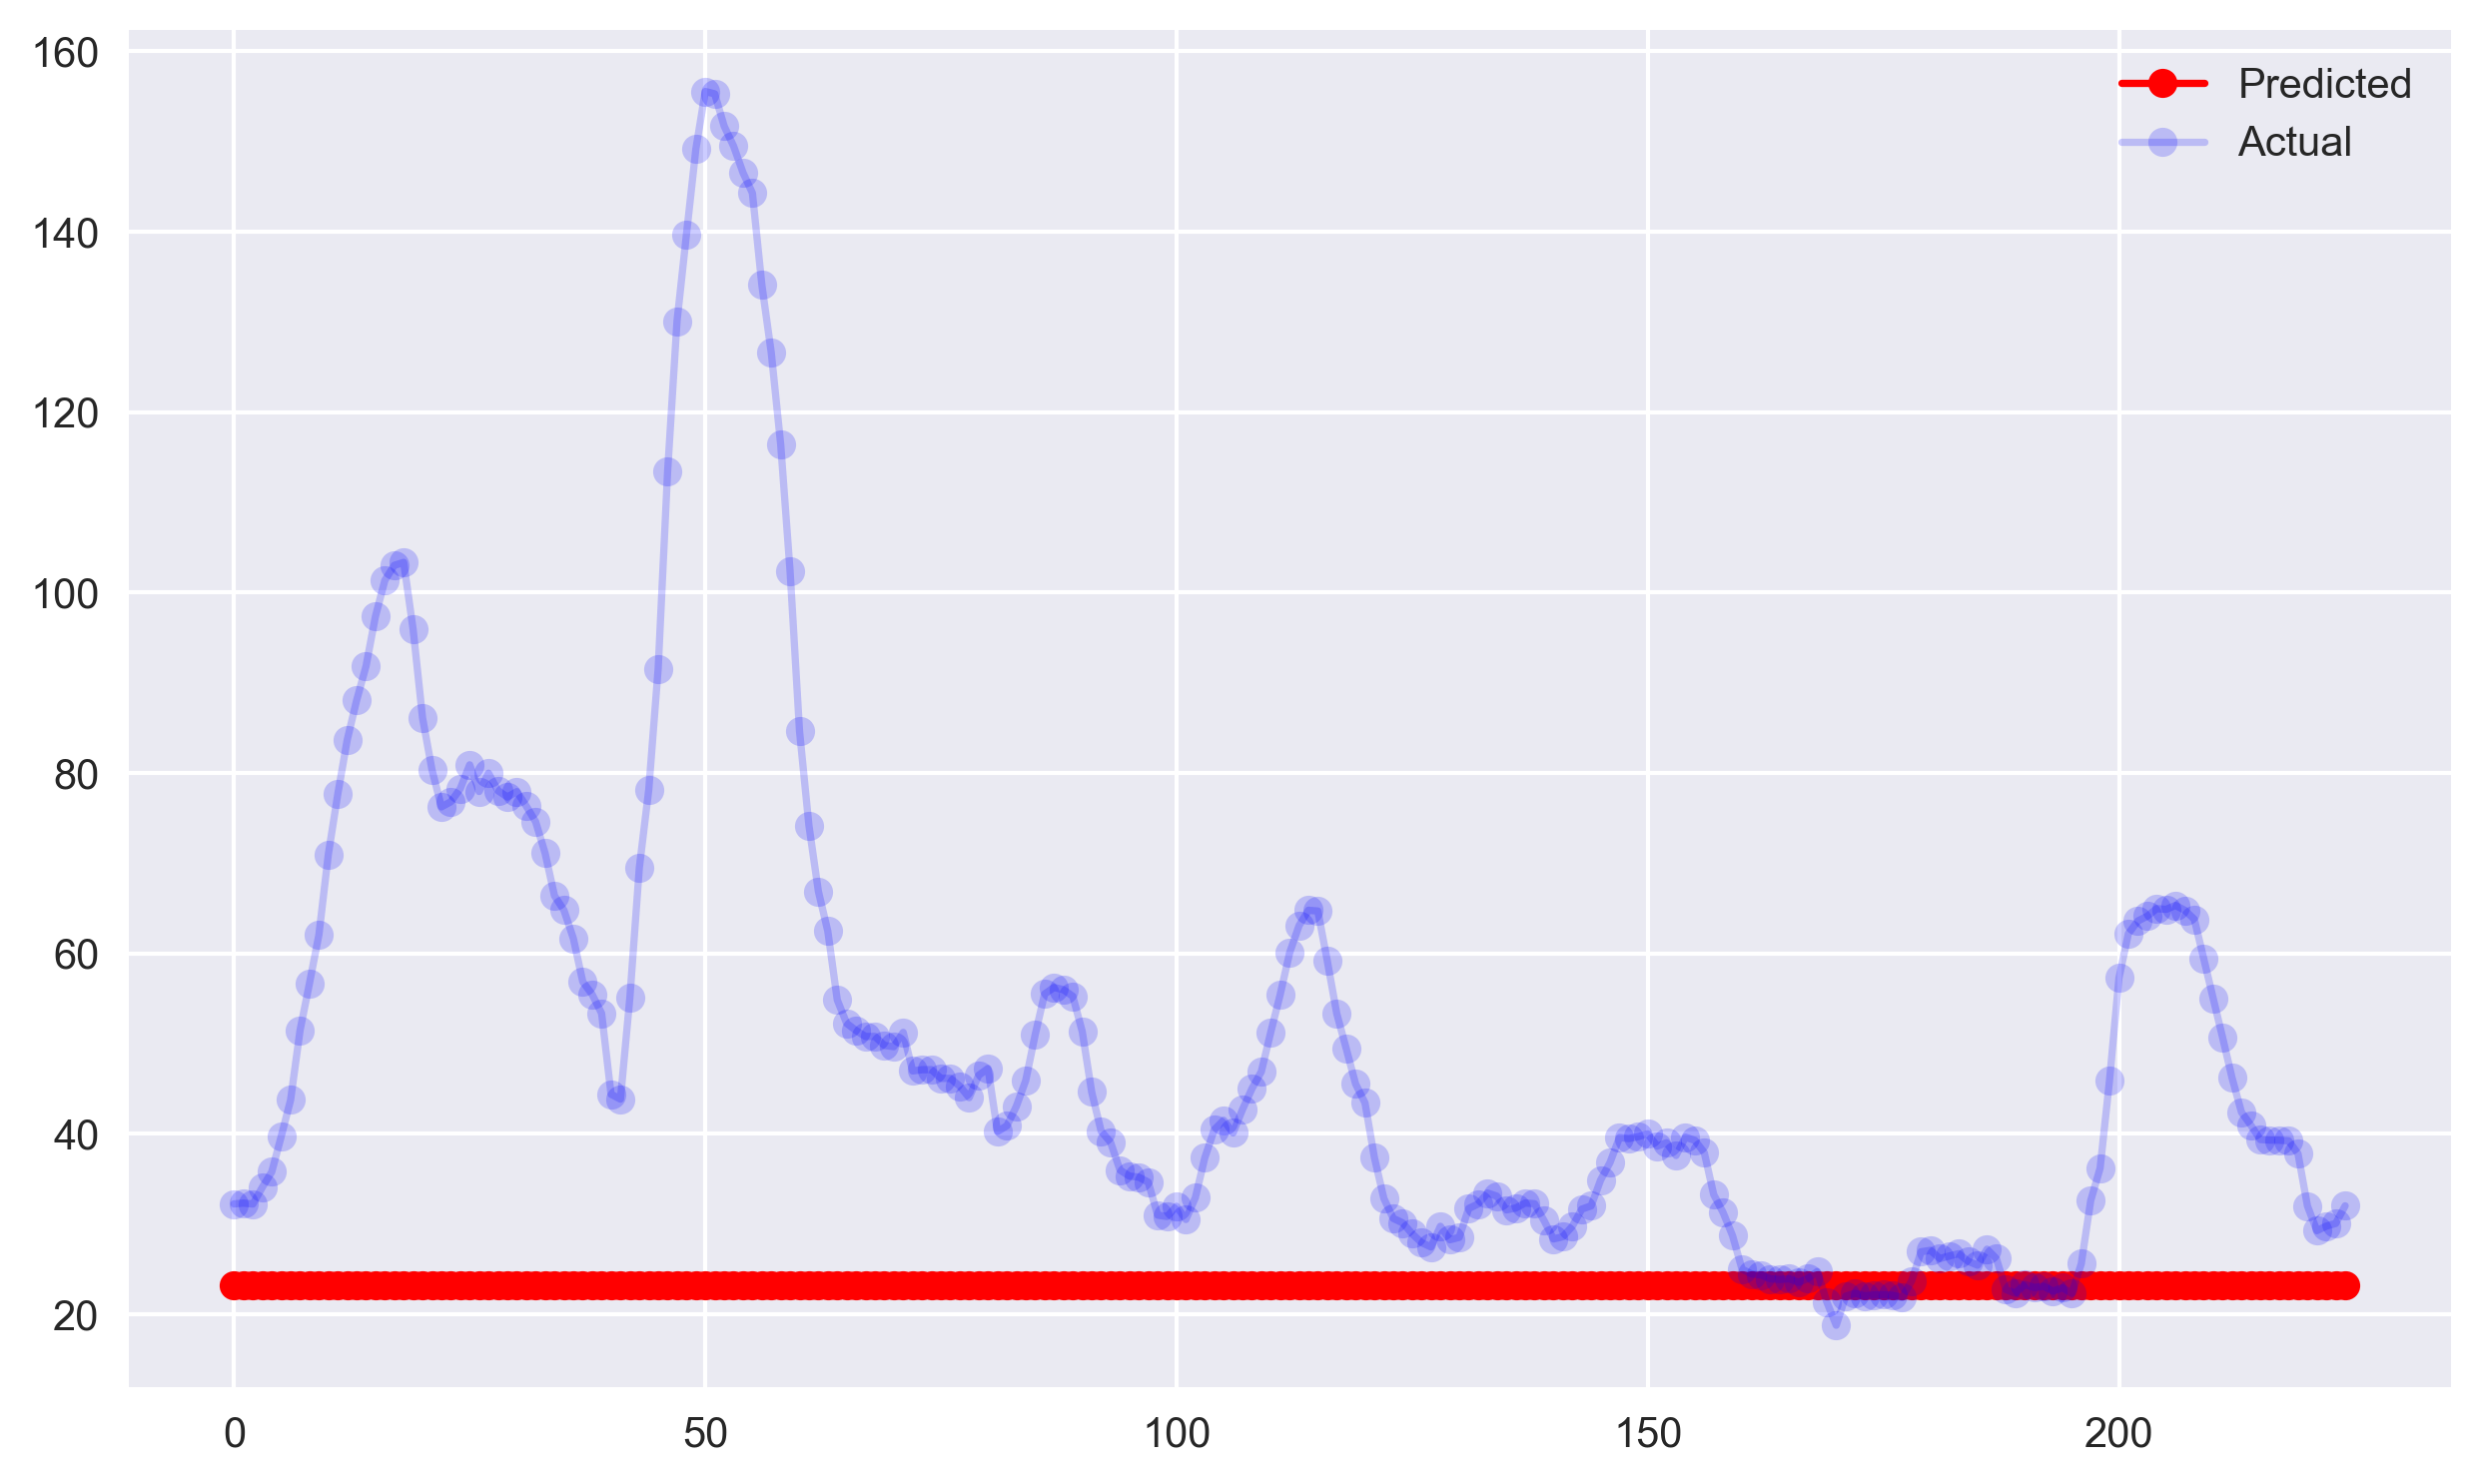

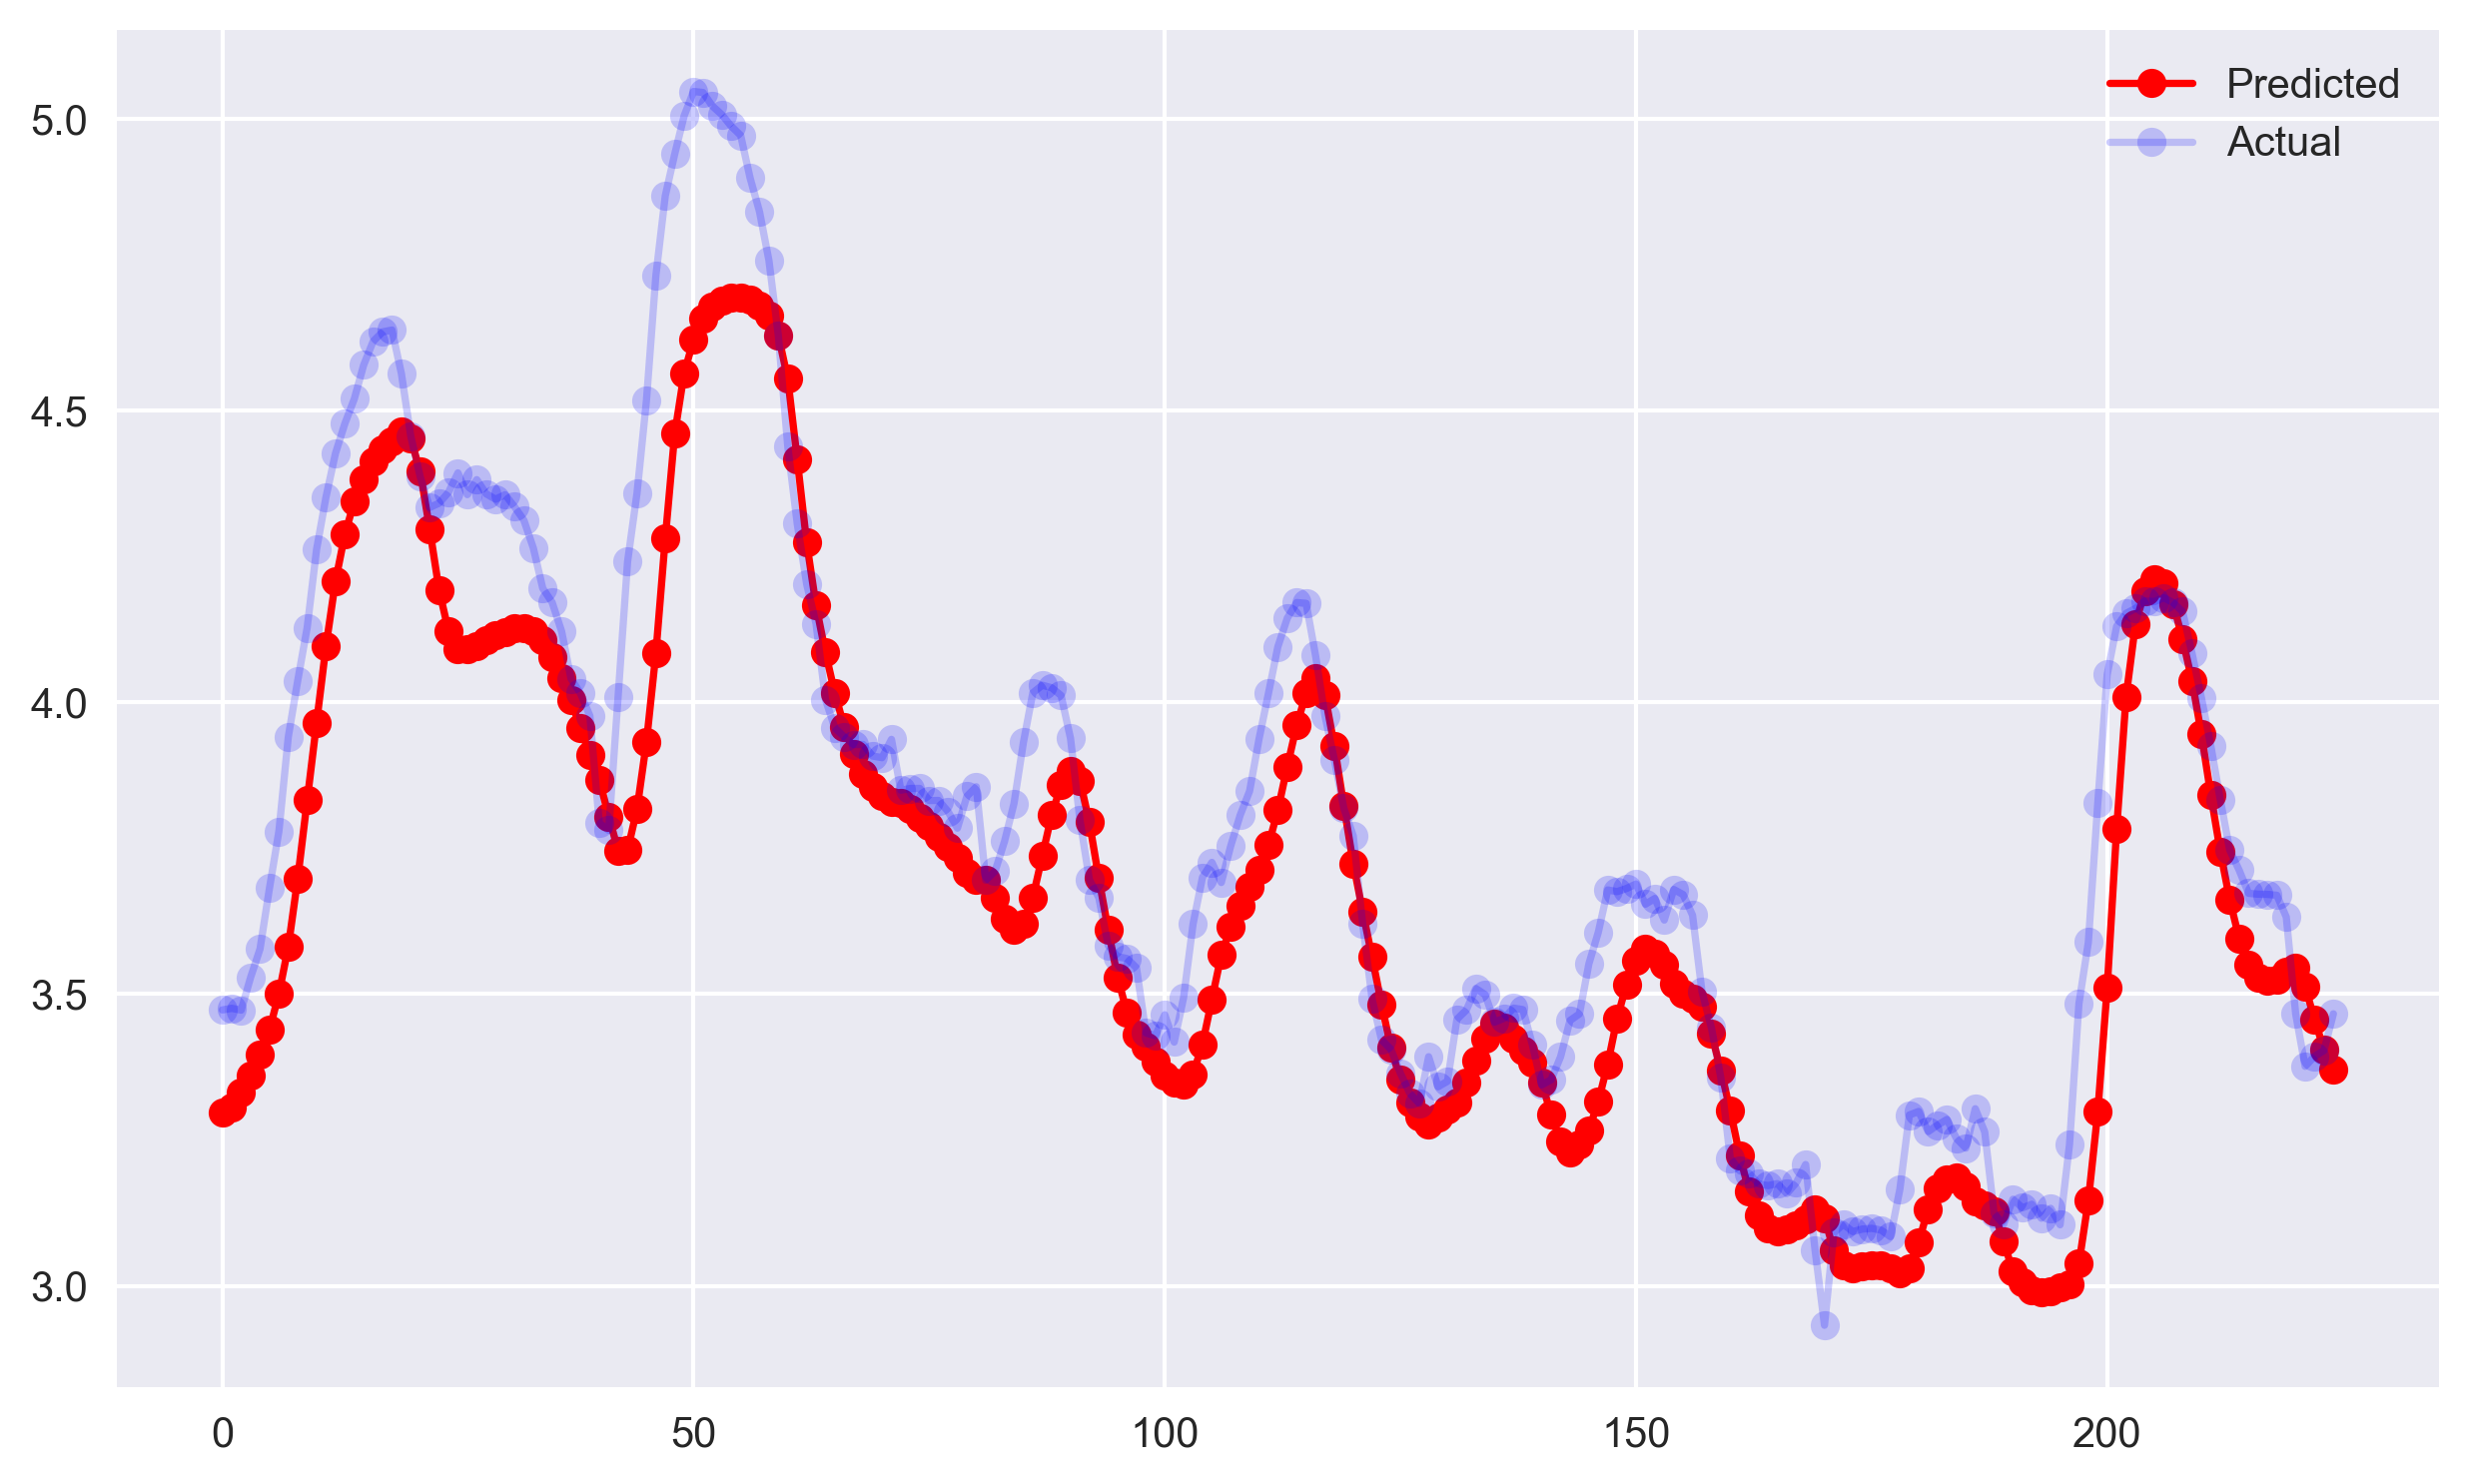

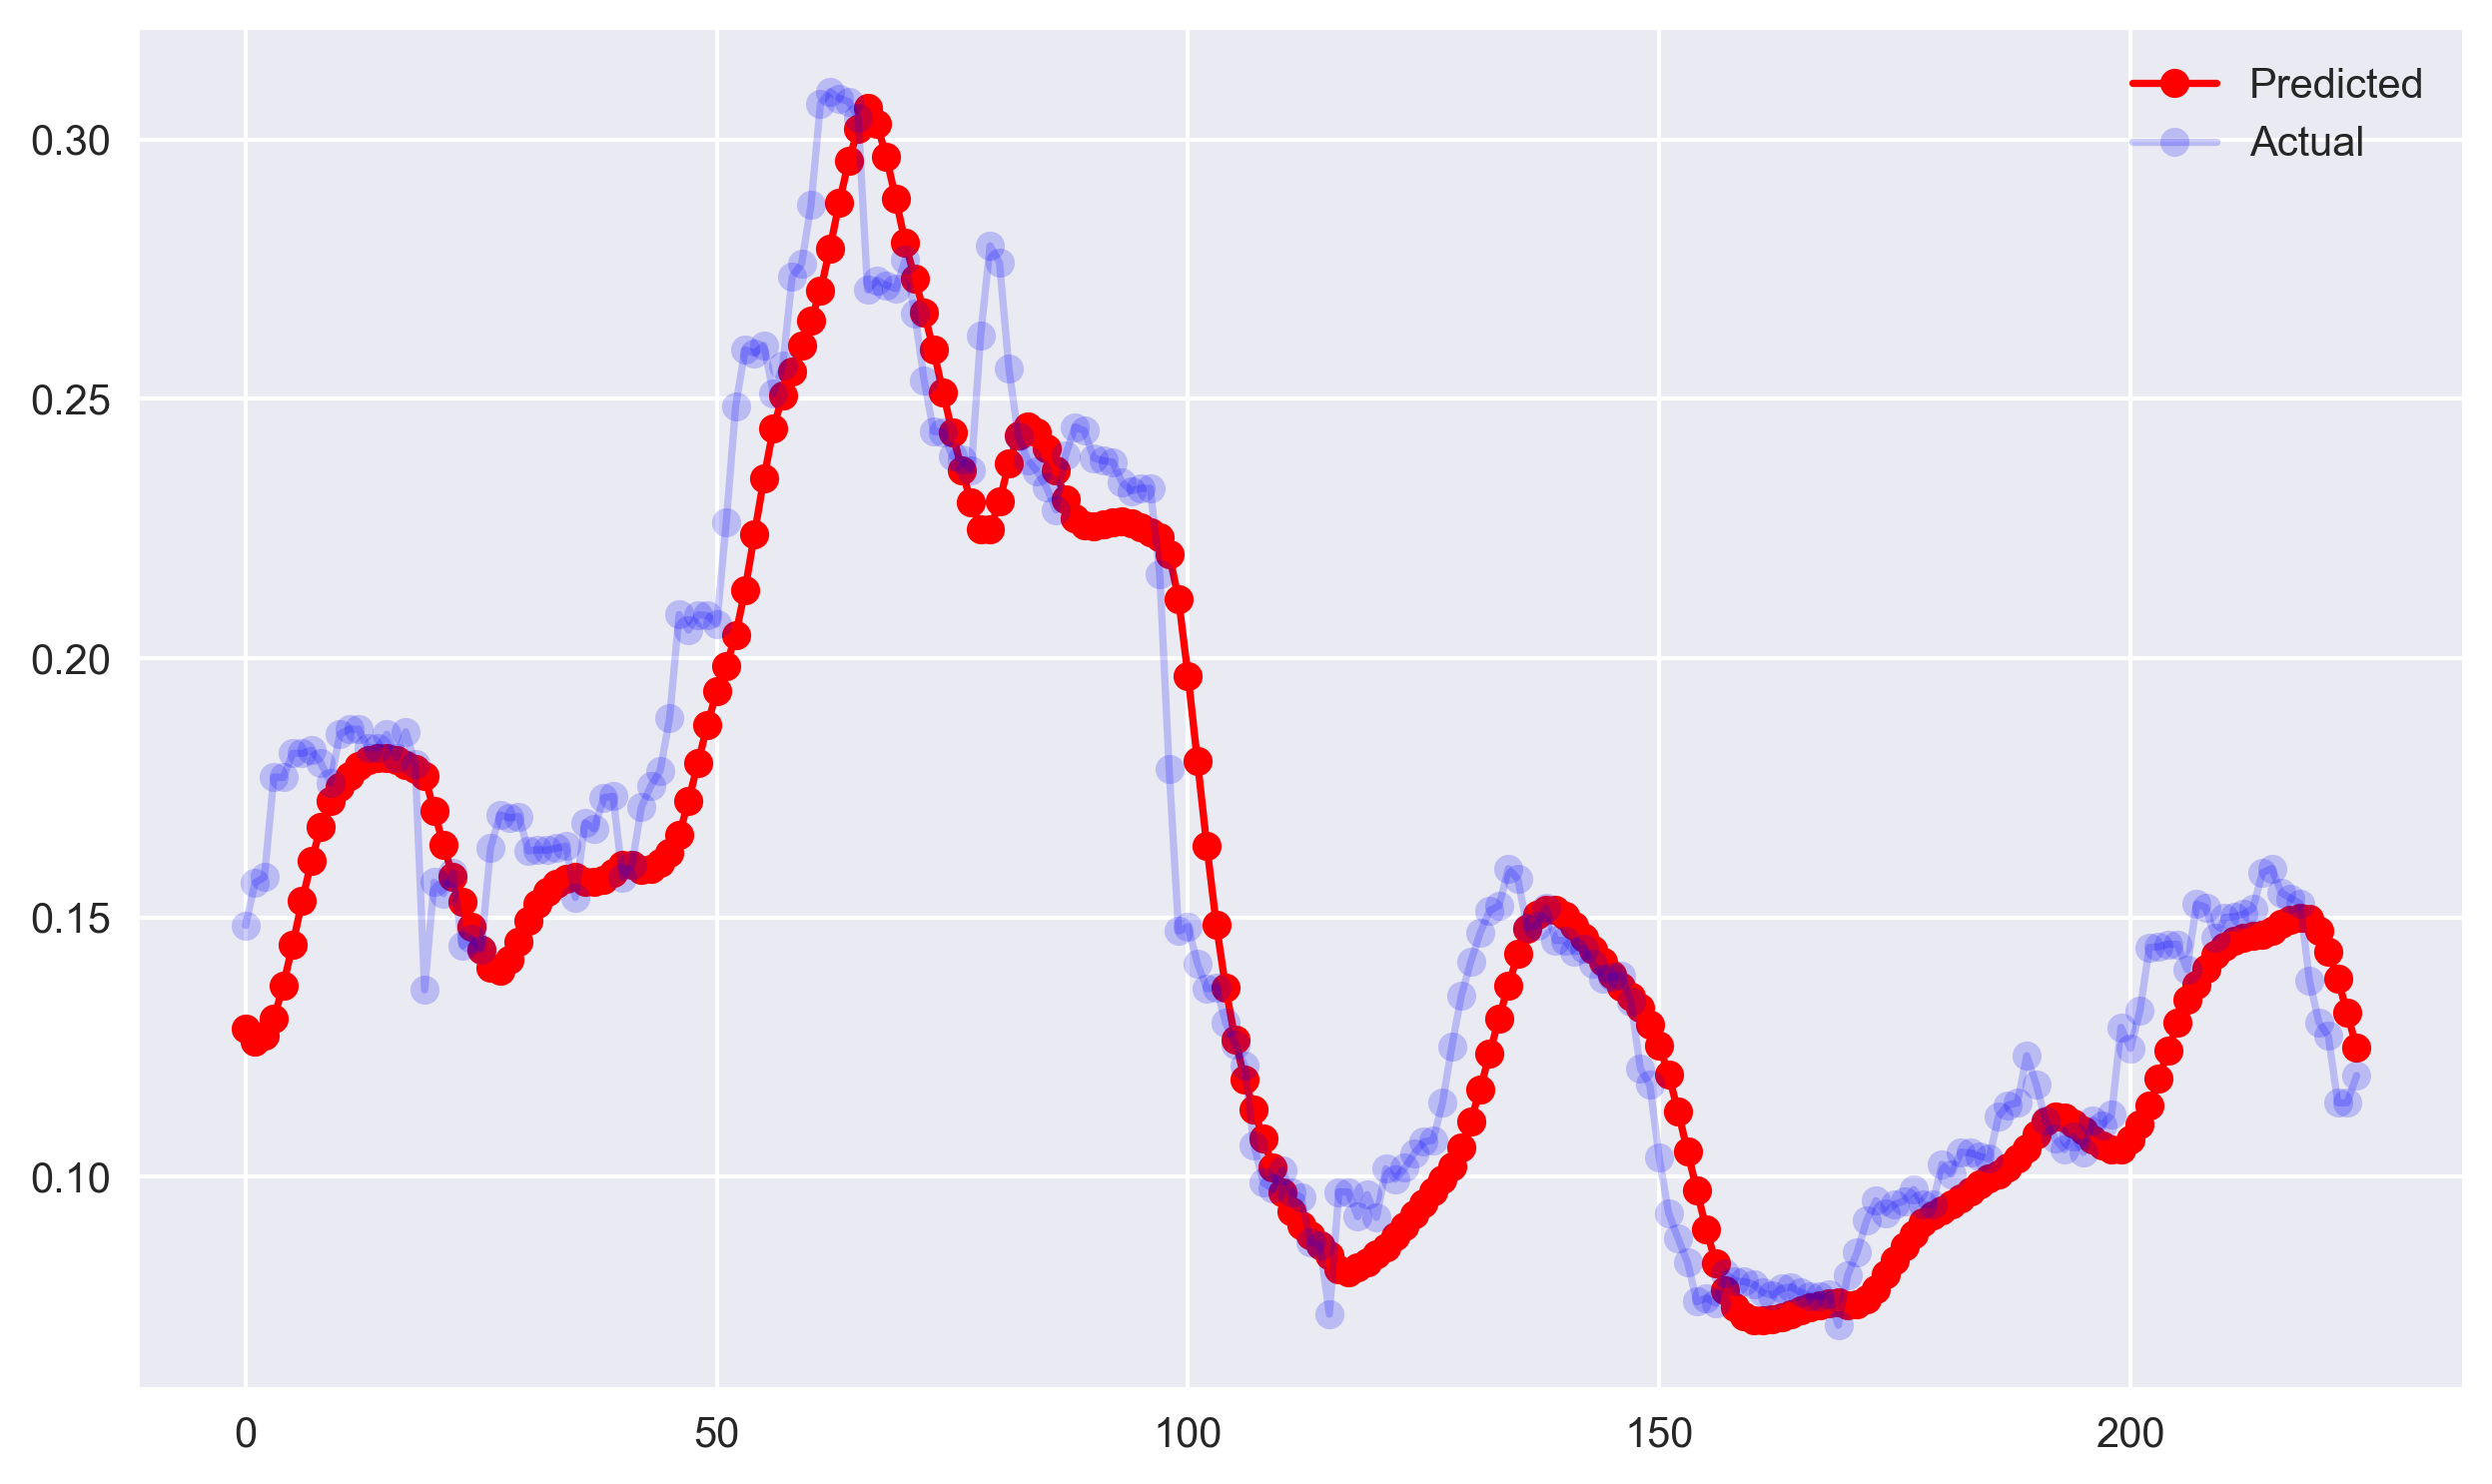

In [15]:
y_hat = []
for i, j in zip(models, X_test):
    y_hat.append(i.predict(j, batch_size=1))

for i, j in zip(y_hat, y_test):
    a_axis = np.arange(0, i.shape[0])
    b_axis = np.arange(0, j.shape[0])
    plt.figure(figsize=(10,6))
    plt.plot(b_axis, i.reshape(i.shape[0],), 'o-', color='red', label='Predicted')
    plt.plot(b_axis, j.reshape(j.shape[0],), 'o-', color='blue', alpha=0.2, label='Actual')
    plt.legend()
    plt.show()

In [16]:
for i in histories:
    print(np.mean(np.sqrt(i.history['val_loss'])))

45.41273480780568
0.3408997977438585
0.02338435409817866


In [17]:
from keras.layers import GRU

histories = []
models    = []
for i, j, k, l in zip(X_train, y_train, X_test, y_test):
    
    input  = Input(batch_shape=(None, X_train[0].shape[1], X_train[0].shape[2]))
    gru    = GRU(units=10, return_sequences=False)(input)
    output = Dense(units=1)(gru)
    
    model = Model(input, output)
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(i, j, validation_data=(k, l), epochs=5, batch_size=20, verbose=1)
    models.append(model)
    histories.append(history)

Epoch 1/5
210/210 [==============================] - 3s 8ms/step - loss: 1279.1803 - val_loss: 3043.9434
Epoch 2/5
210/210 [==============================] - 1s 6ms/step - loss: 1094.3768 - val_loss: 2809.8750
Epoch 3/5
210/210 [==============================] - 1s 6ms/step - loss: 980.8671 - val_loss: 2622.4919
Epoch 4/5
210/210 [==============================] - 1s 6ms/step - loss: 886.1241 - val_loss: 2454.8943
Epoch 5/5
210/210 [==============================] - 1s 6ms/step - loss: 804.9627 - val_loss: 2304.7161
Epoch 1/5
210/210 [==============================] - 4s 8ms/step - loss: 2.7137 - val_loss: 0.4590
Epoch 2/5
210/210 [==============================] - 1s 6ms/step - loss: 0.2002 - val_loss: 0.3670
Epoch 3/5
210/210 [==============================] - 1s 6ms/step - loss: 0.1587 - val_loss: 0.2873
Epoch 4/5
210/210 [==============================] - 1s 6ms/step - loss: 0.1203 - val_loss: 0.2228
Epoch 5/5
210/210 [==============================] - 1s 6ms/step - loss: 0.0892 - 

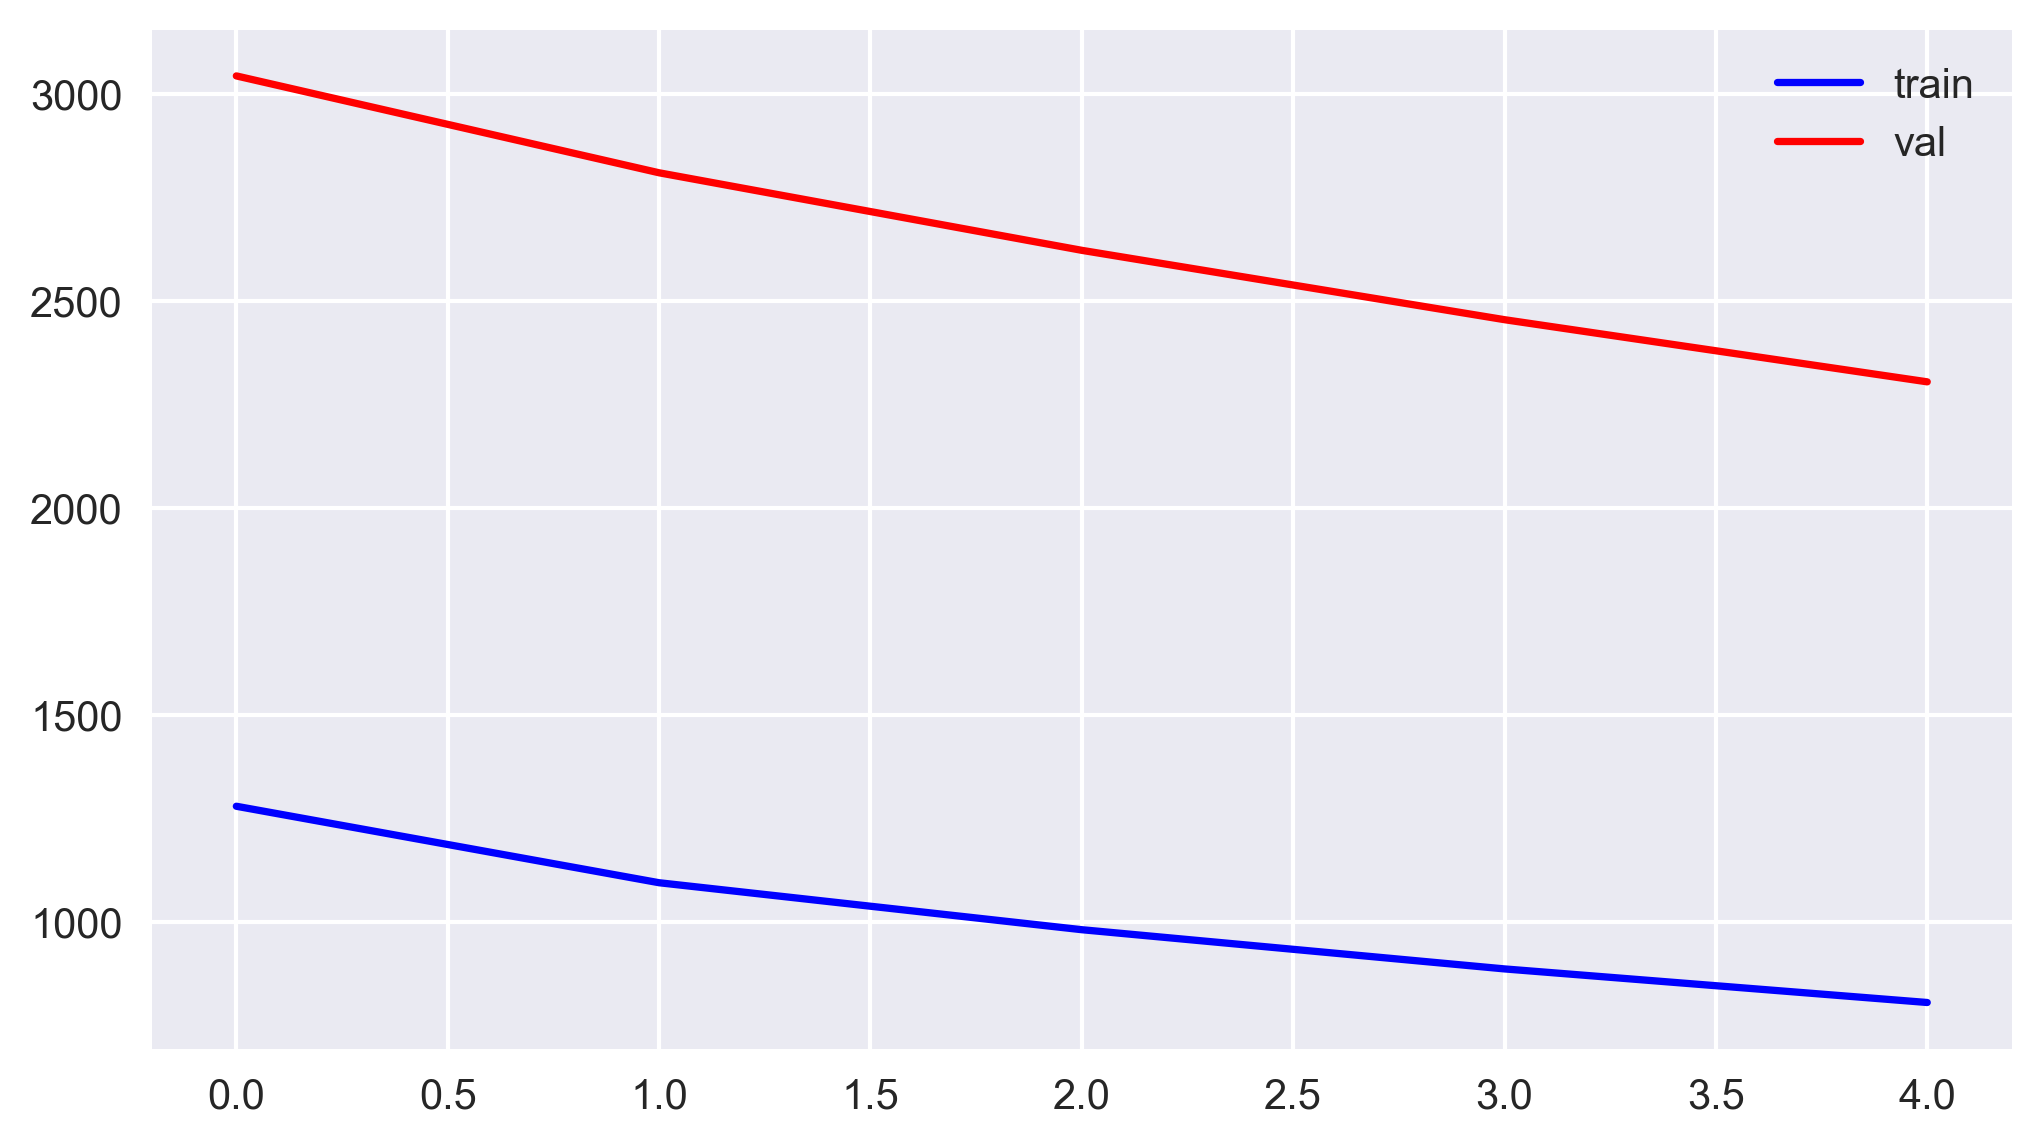

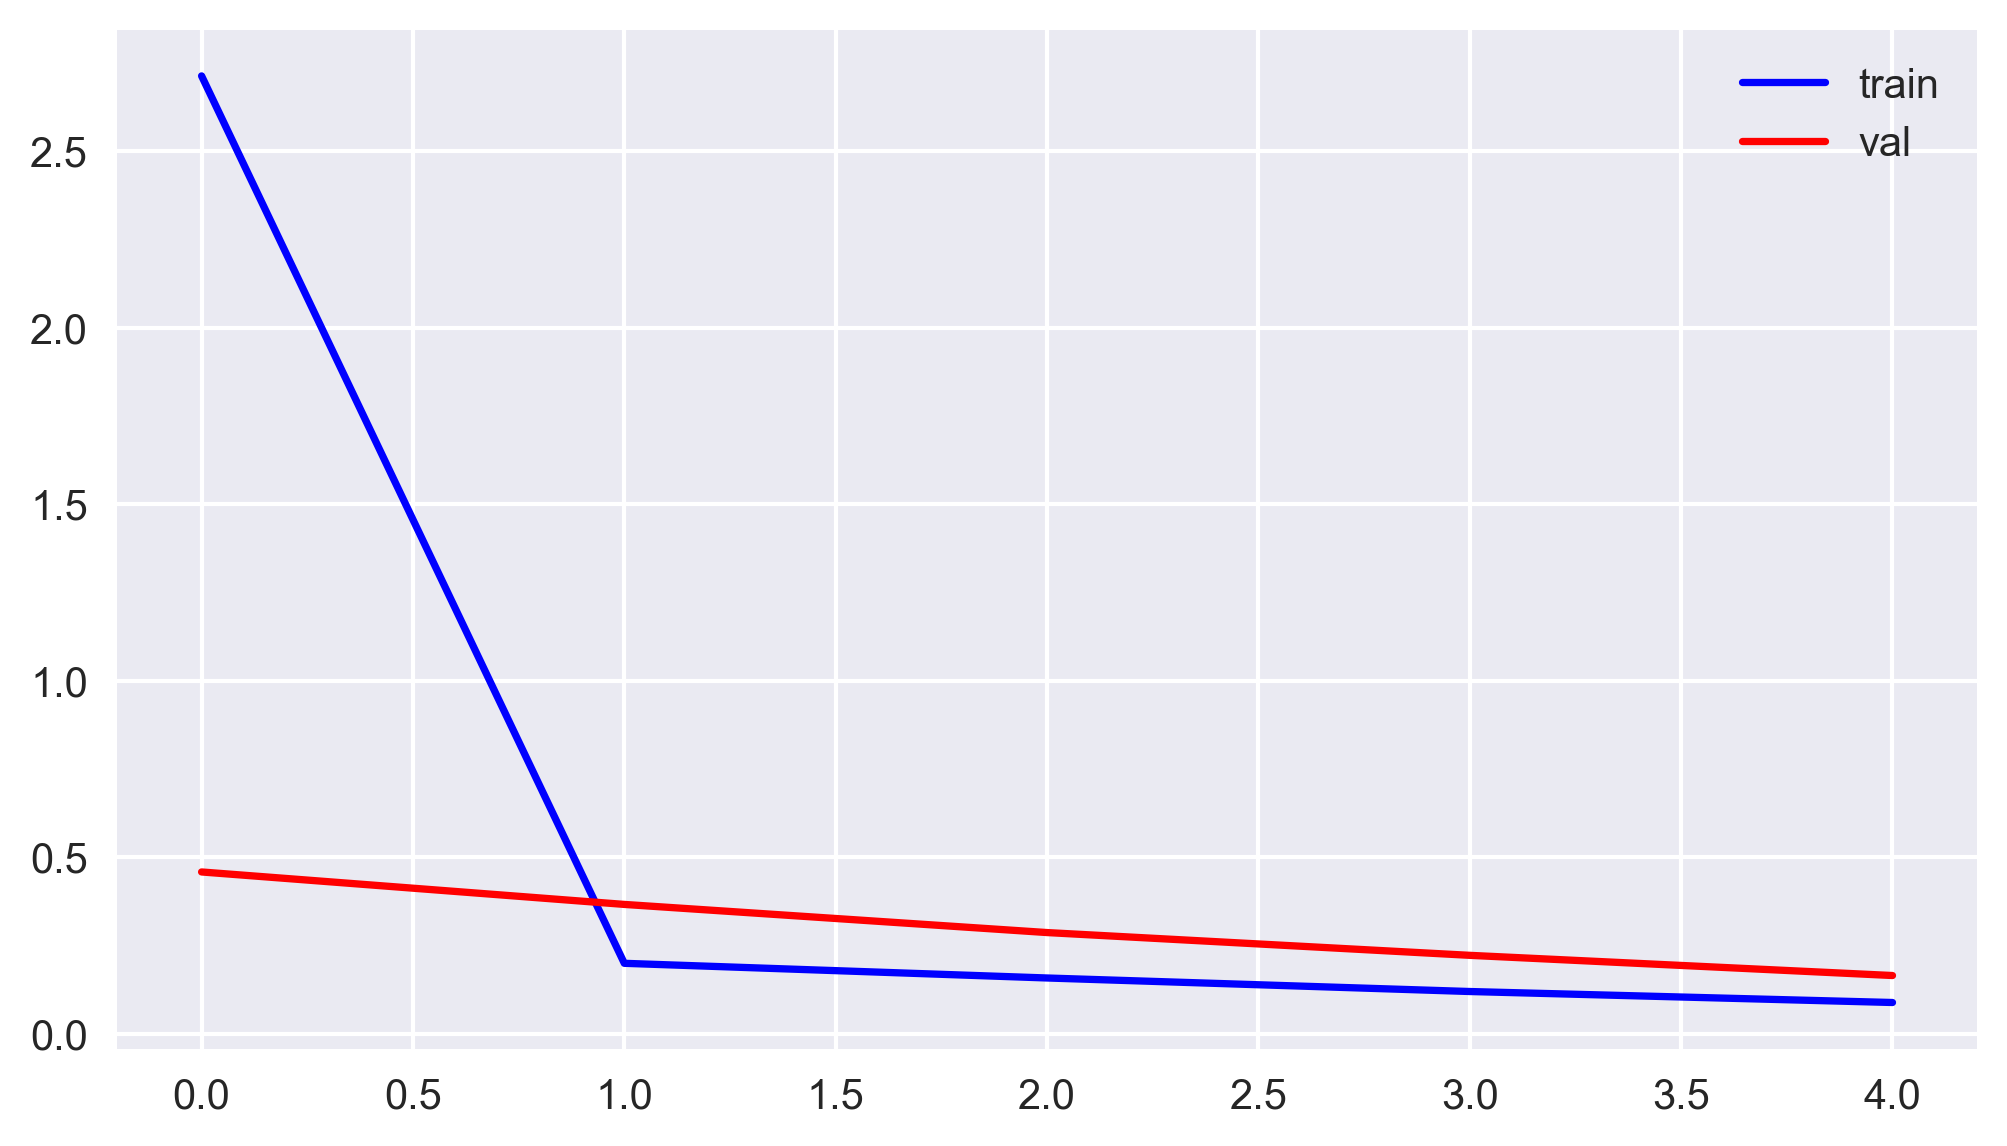

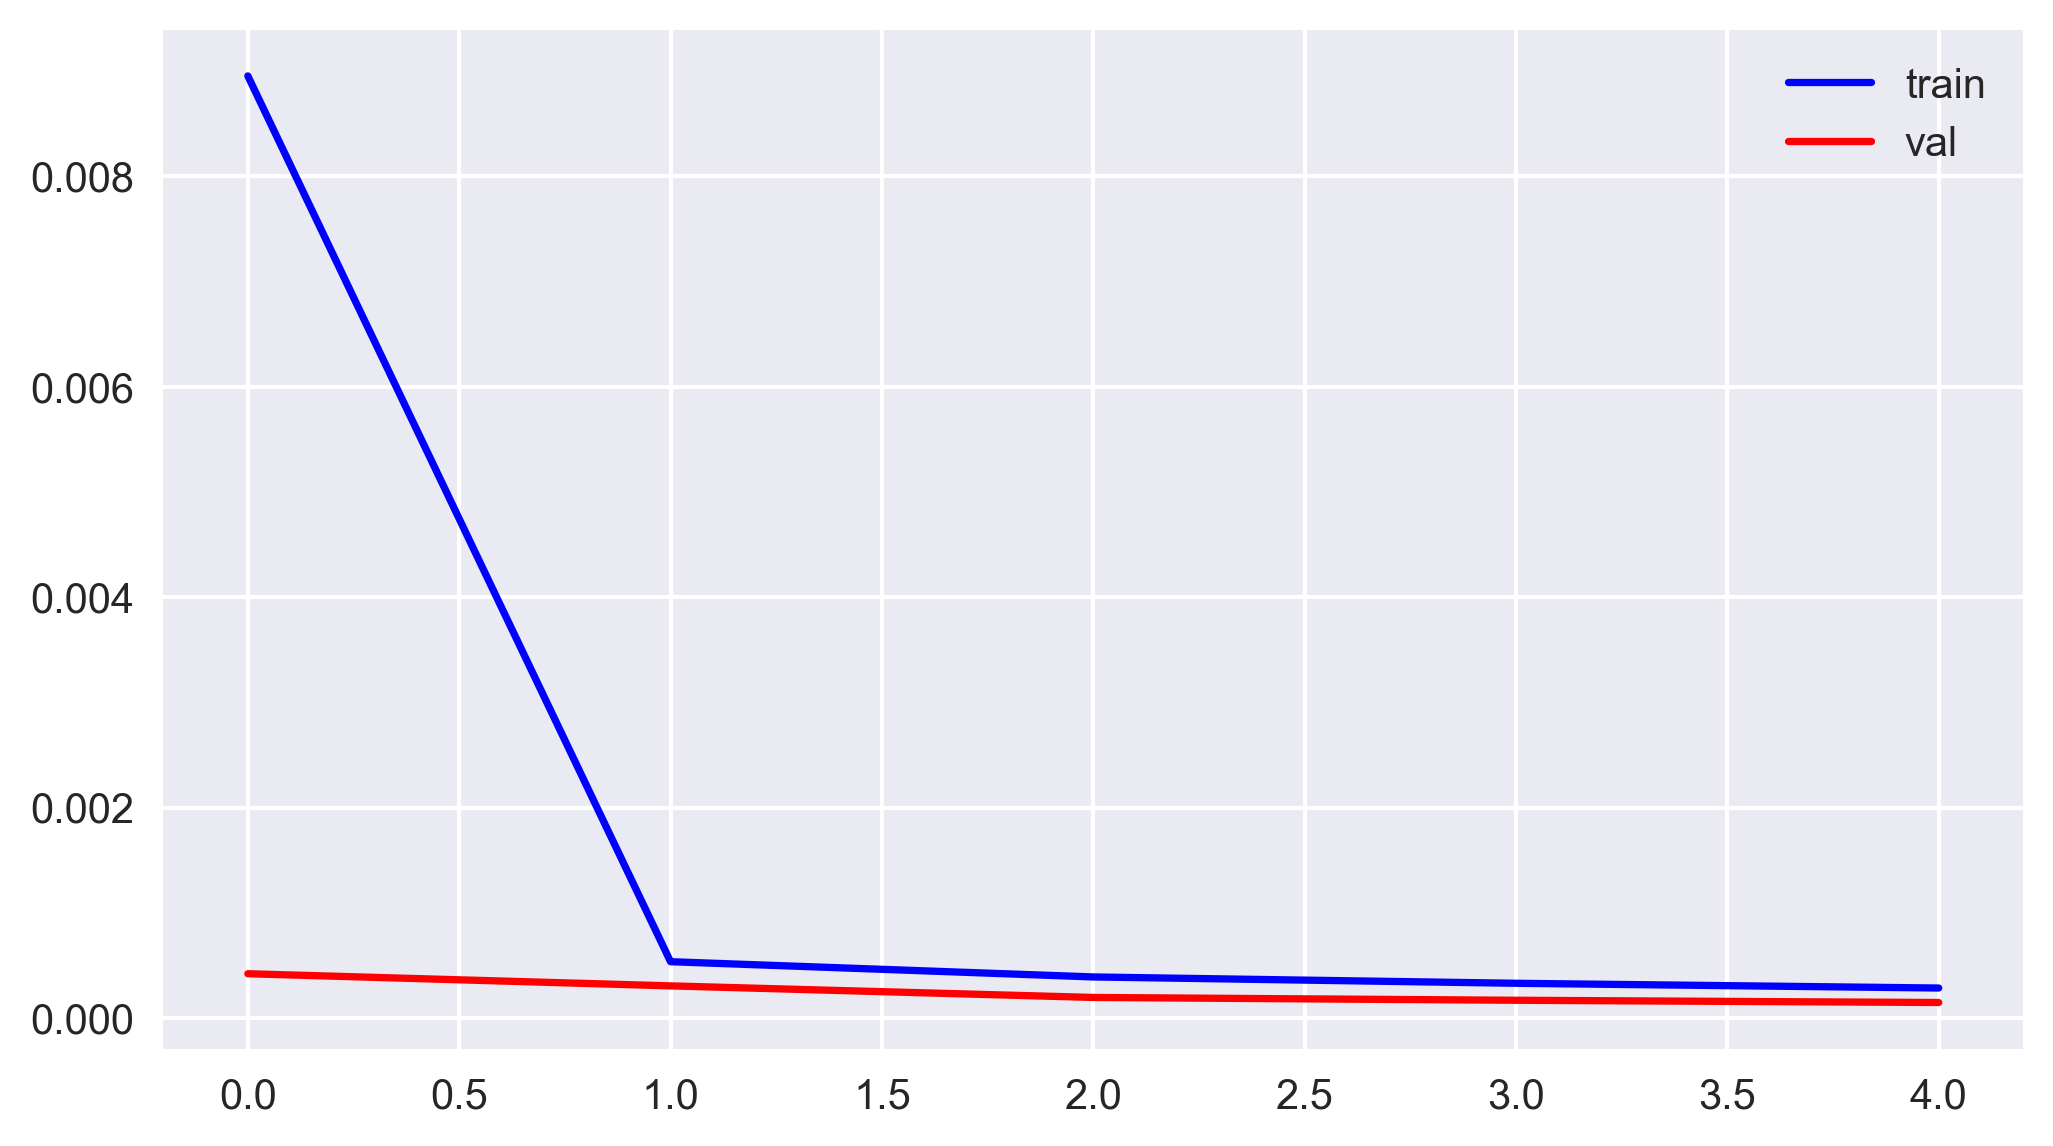

In [18]:
for h in histories:
    train_loss = h.history['loss']
    val_loss   = h.history['val_loss']
    plt.plot(range(len(train_loss)), train_loss, c='b', label='train')
    plt.plot(range(len(val_loss)), val_loss, c='r', label='val')
    plt.legend()
    plt.show()

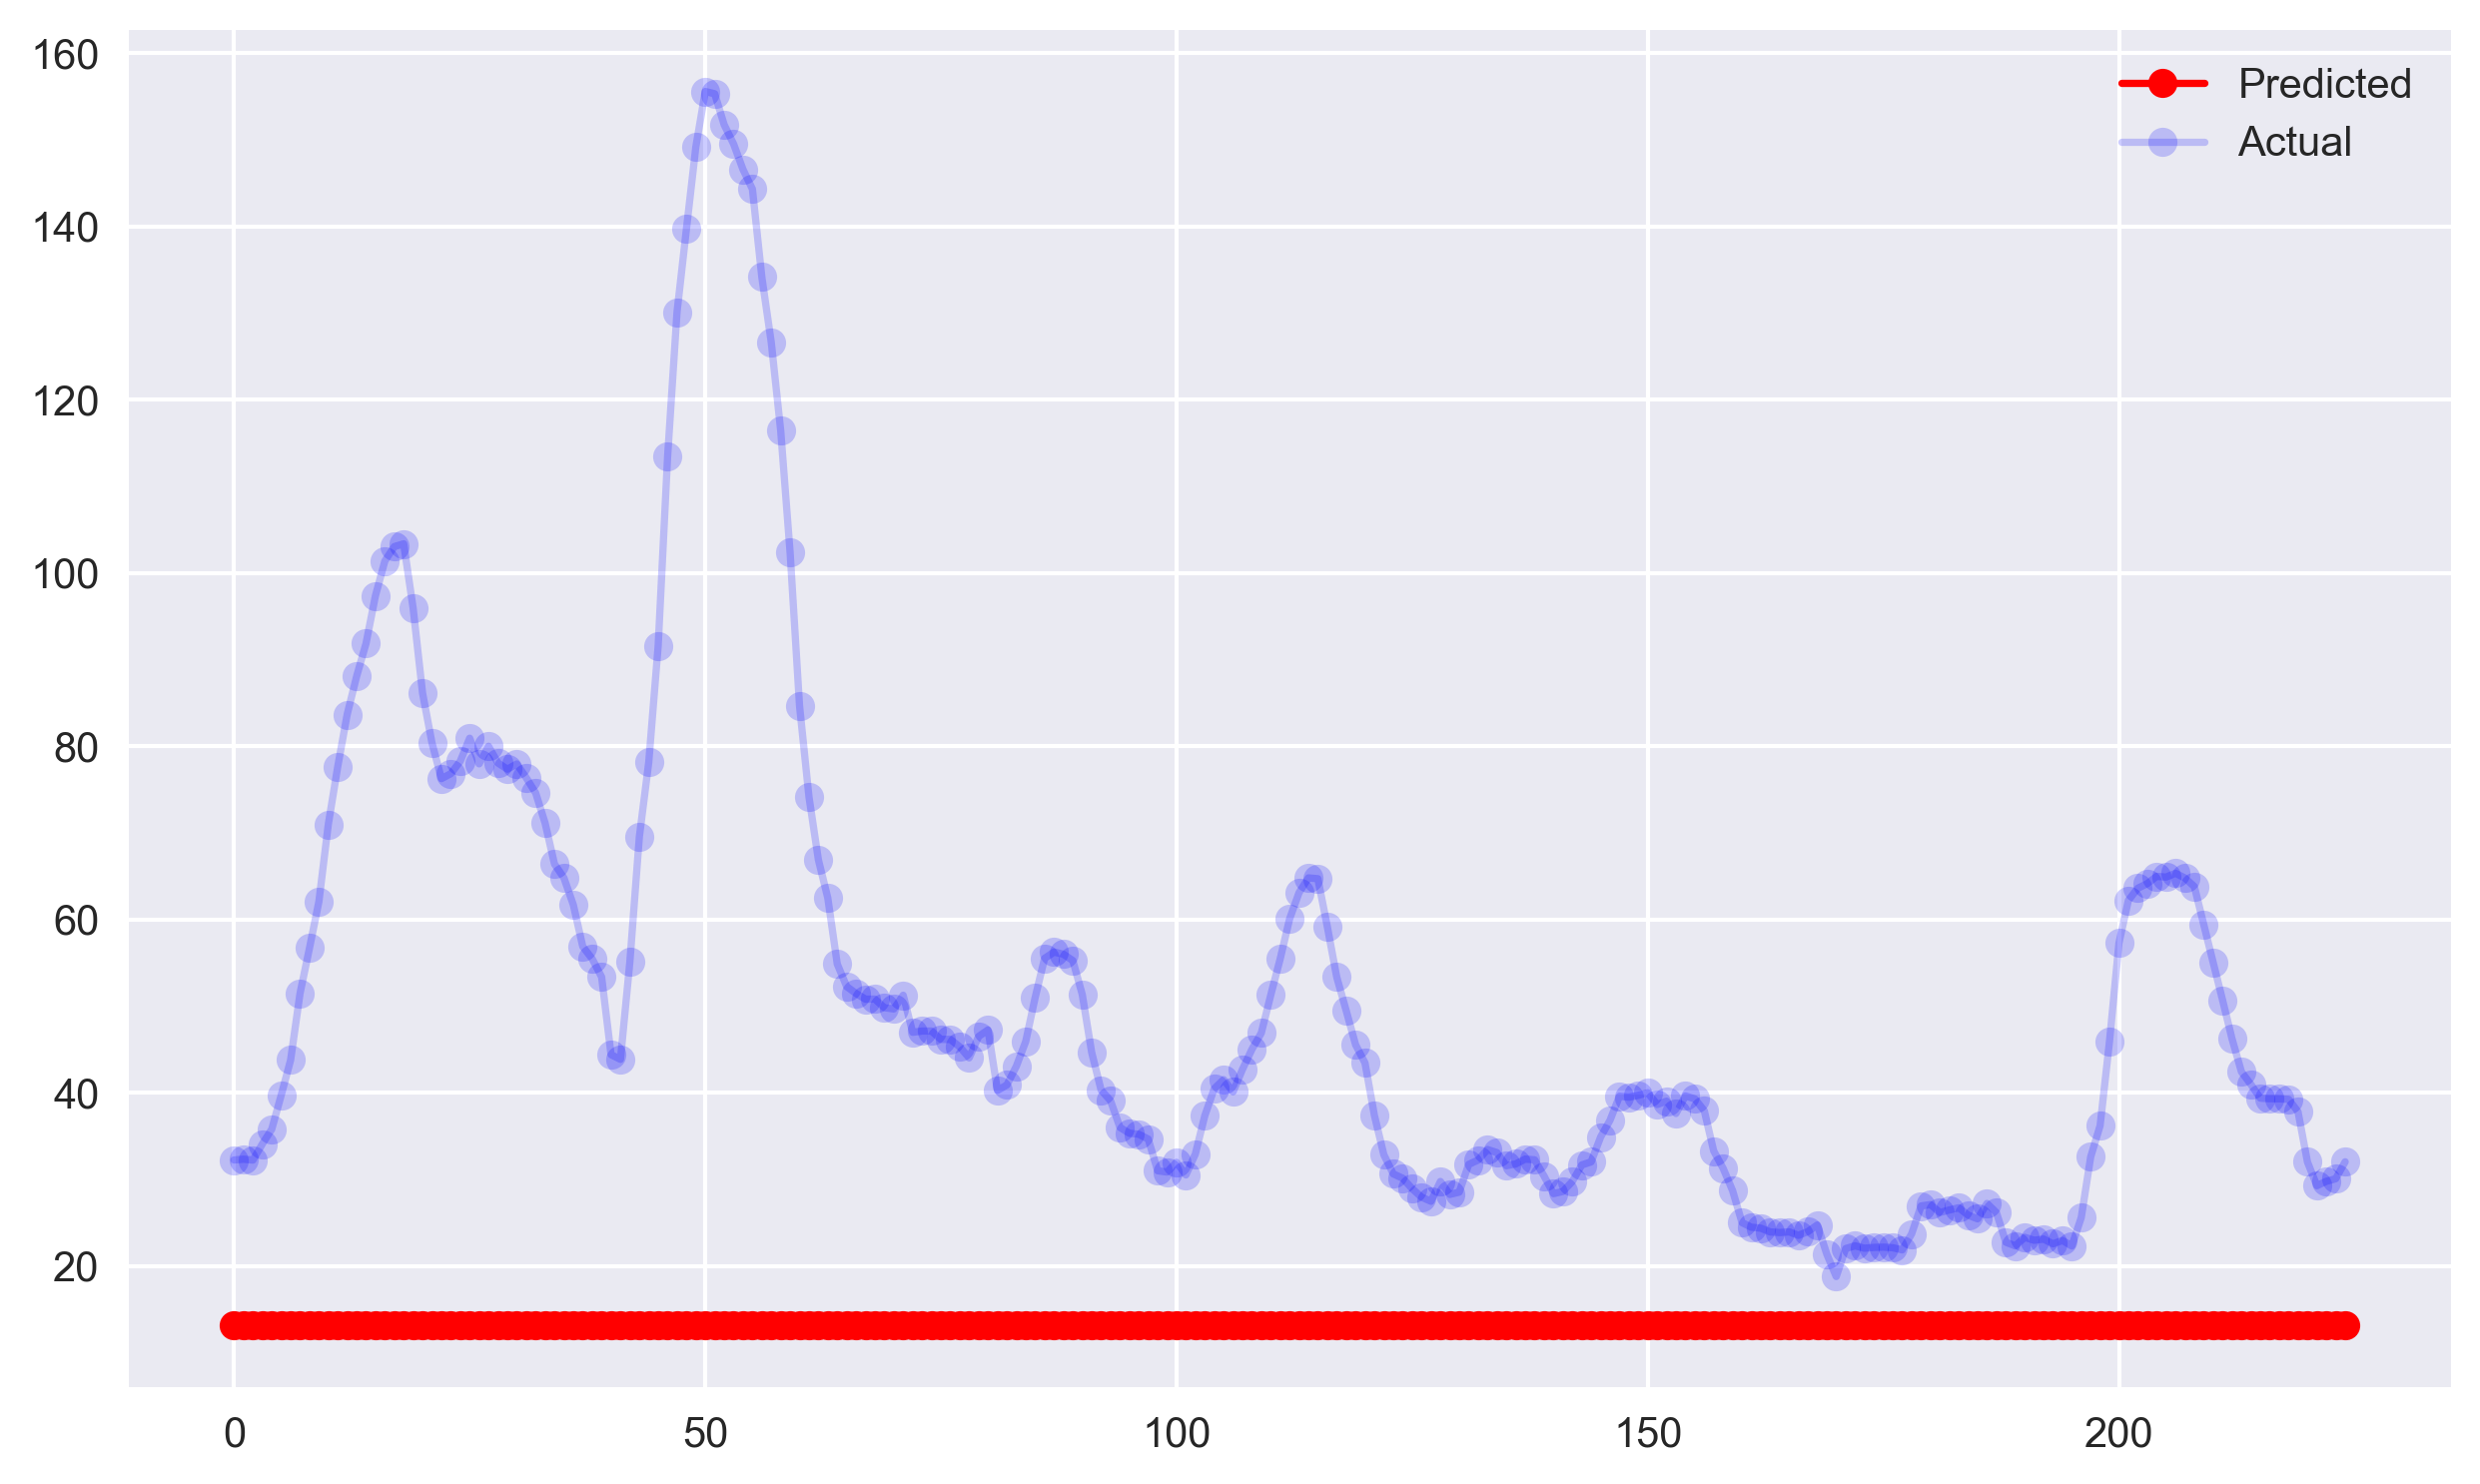

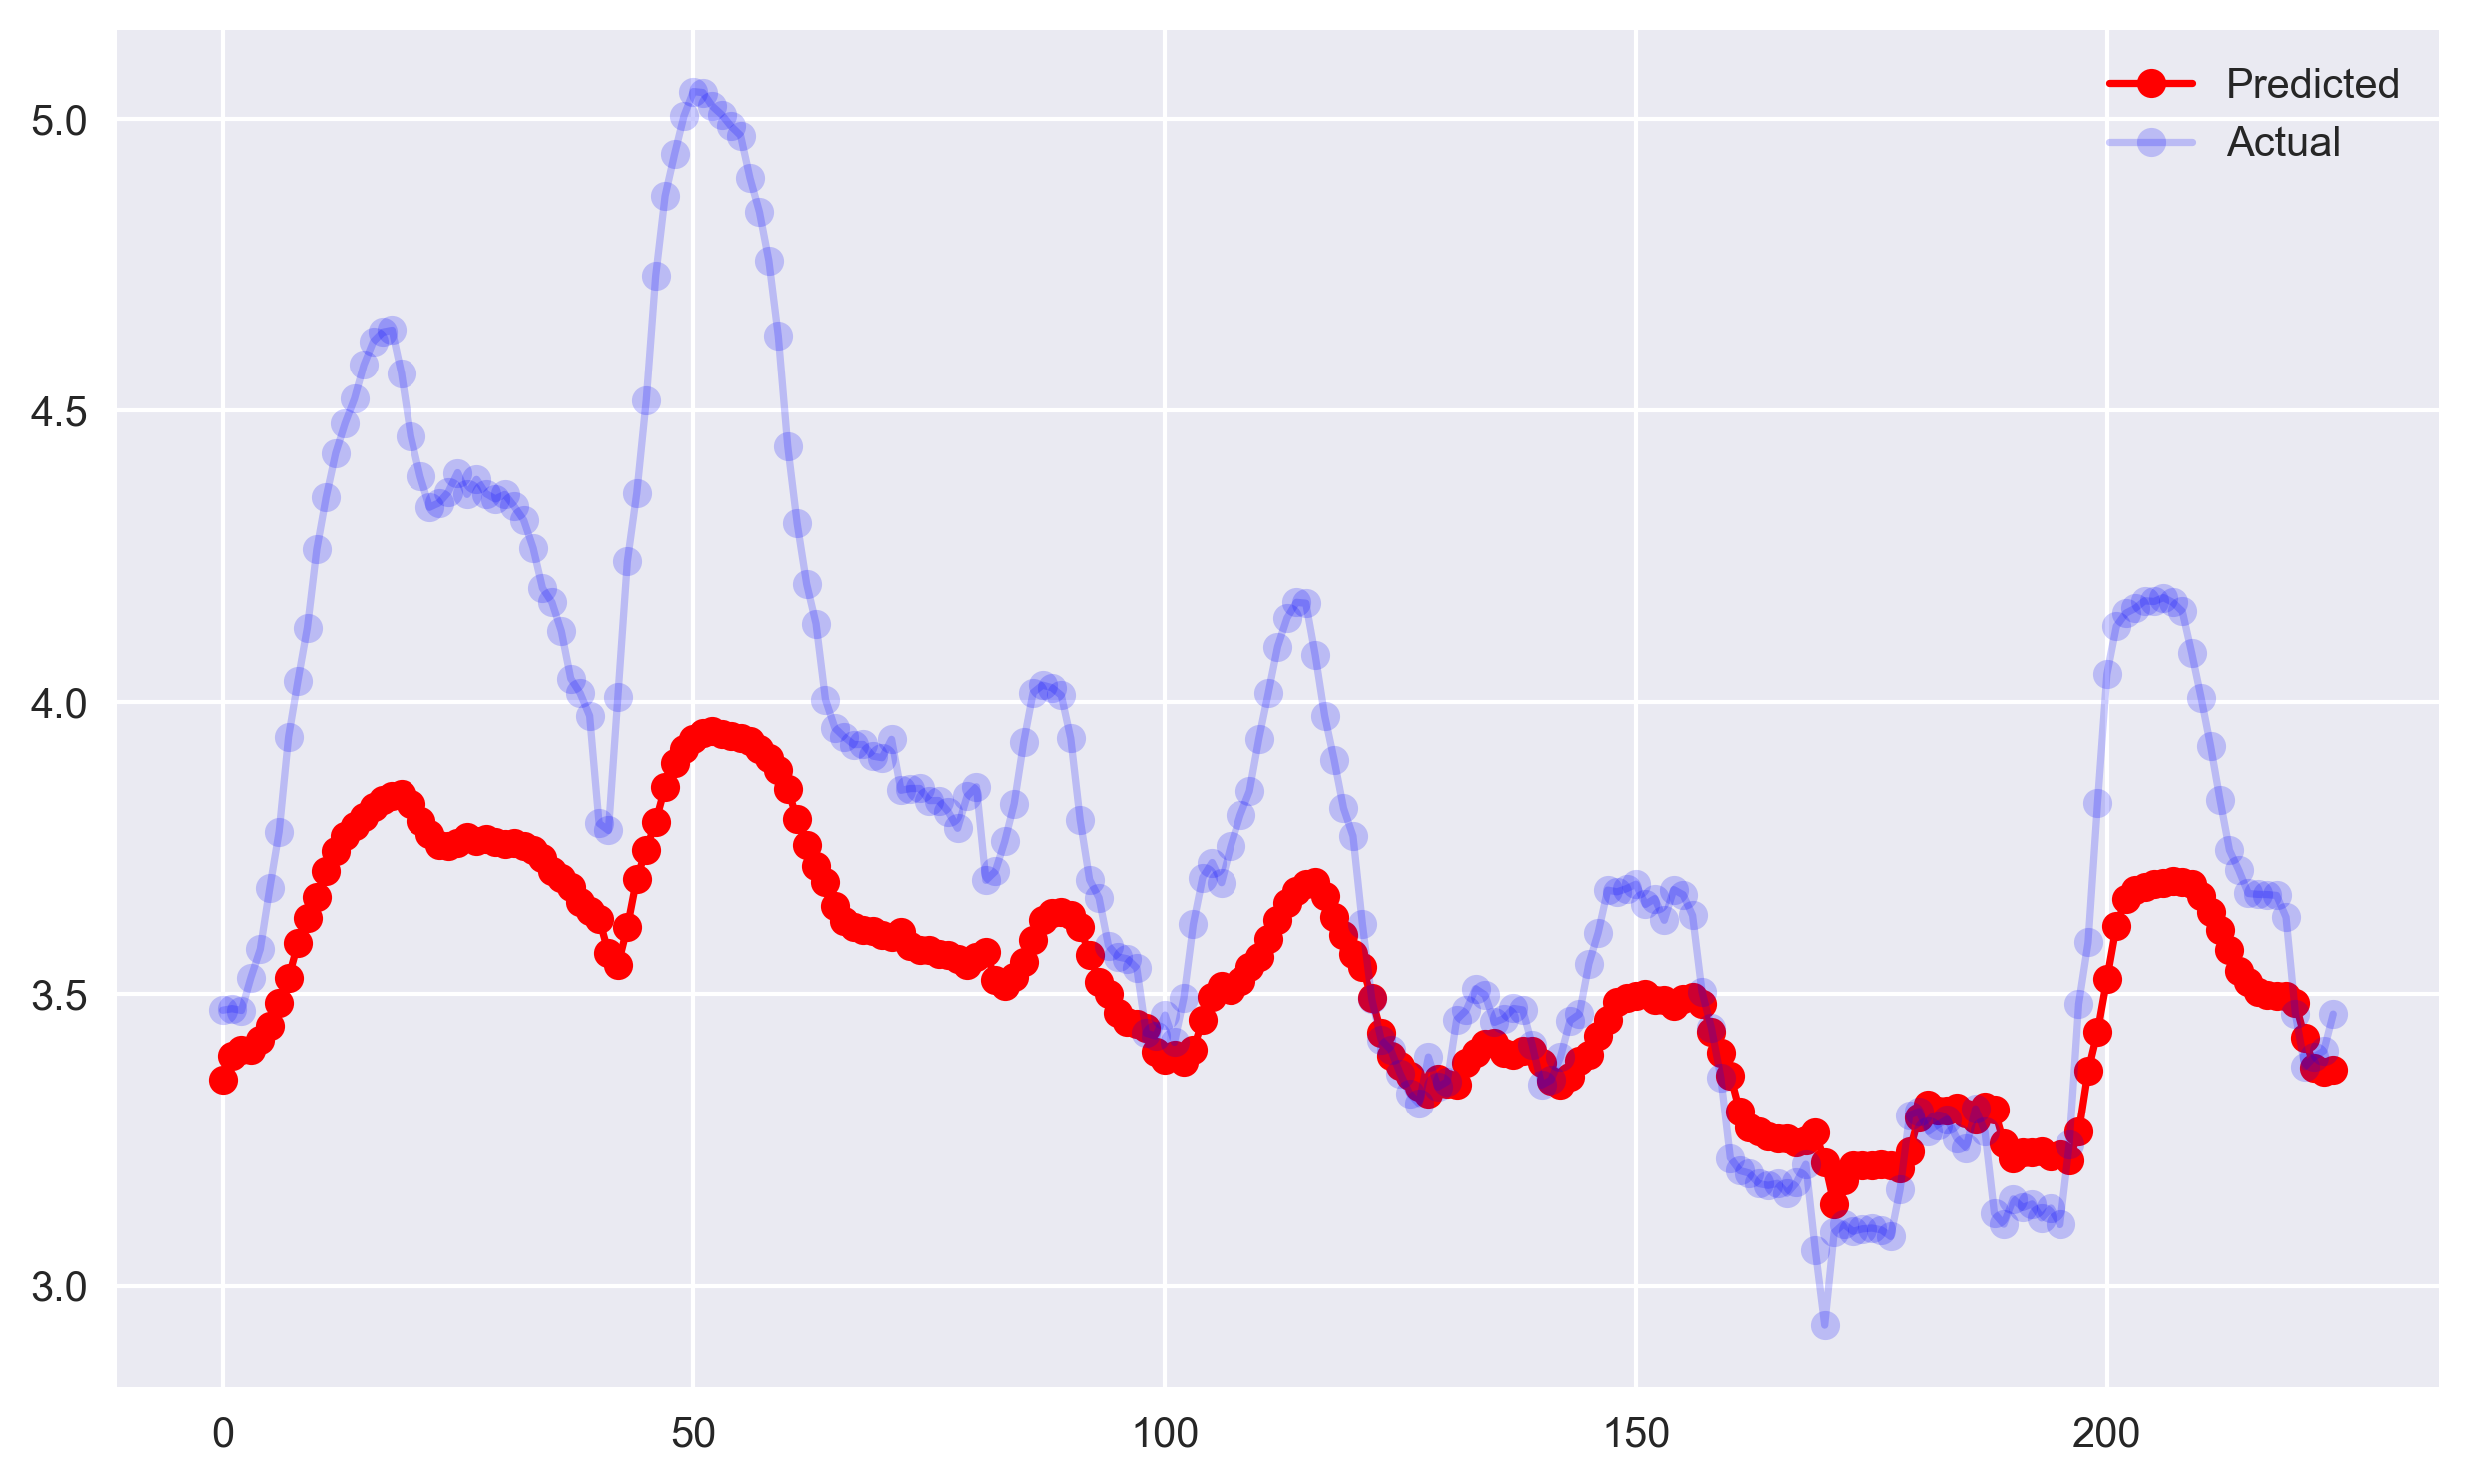

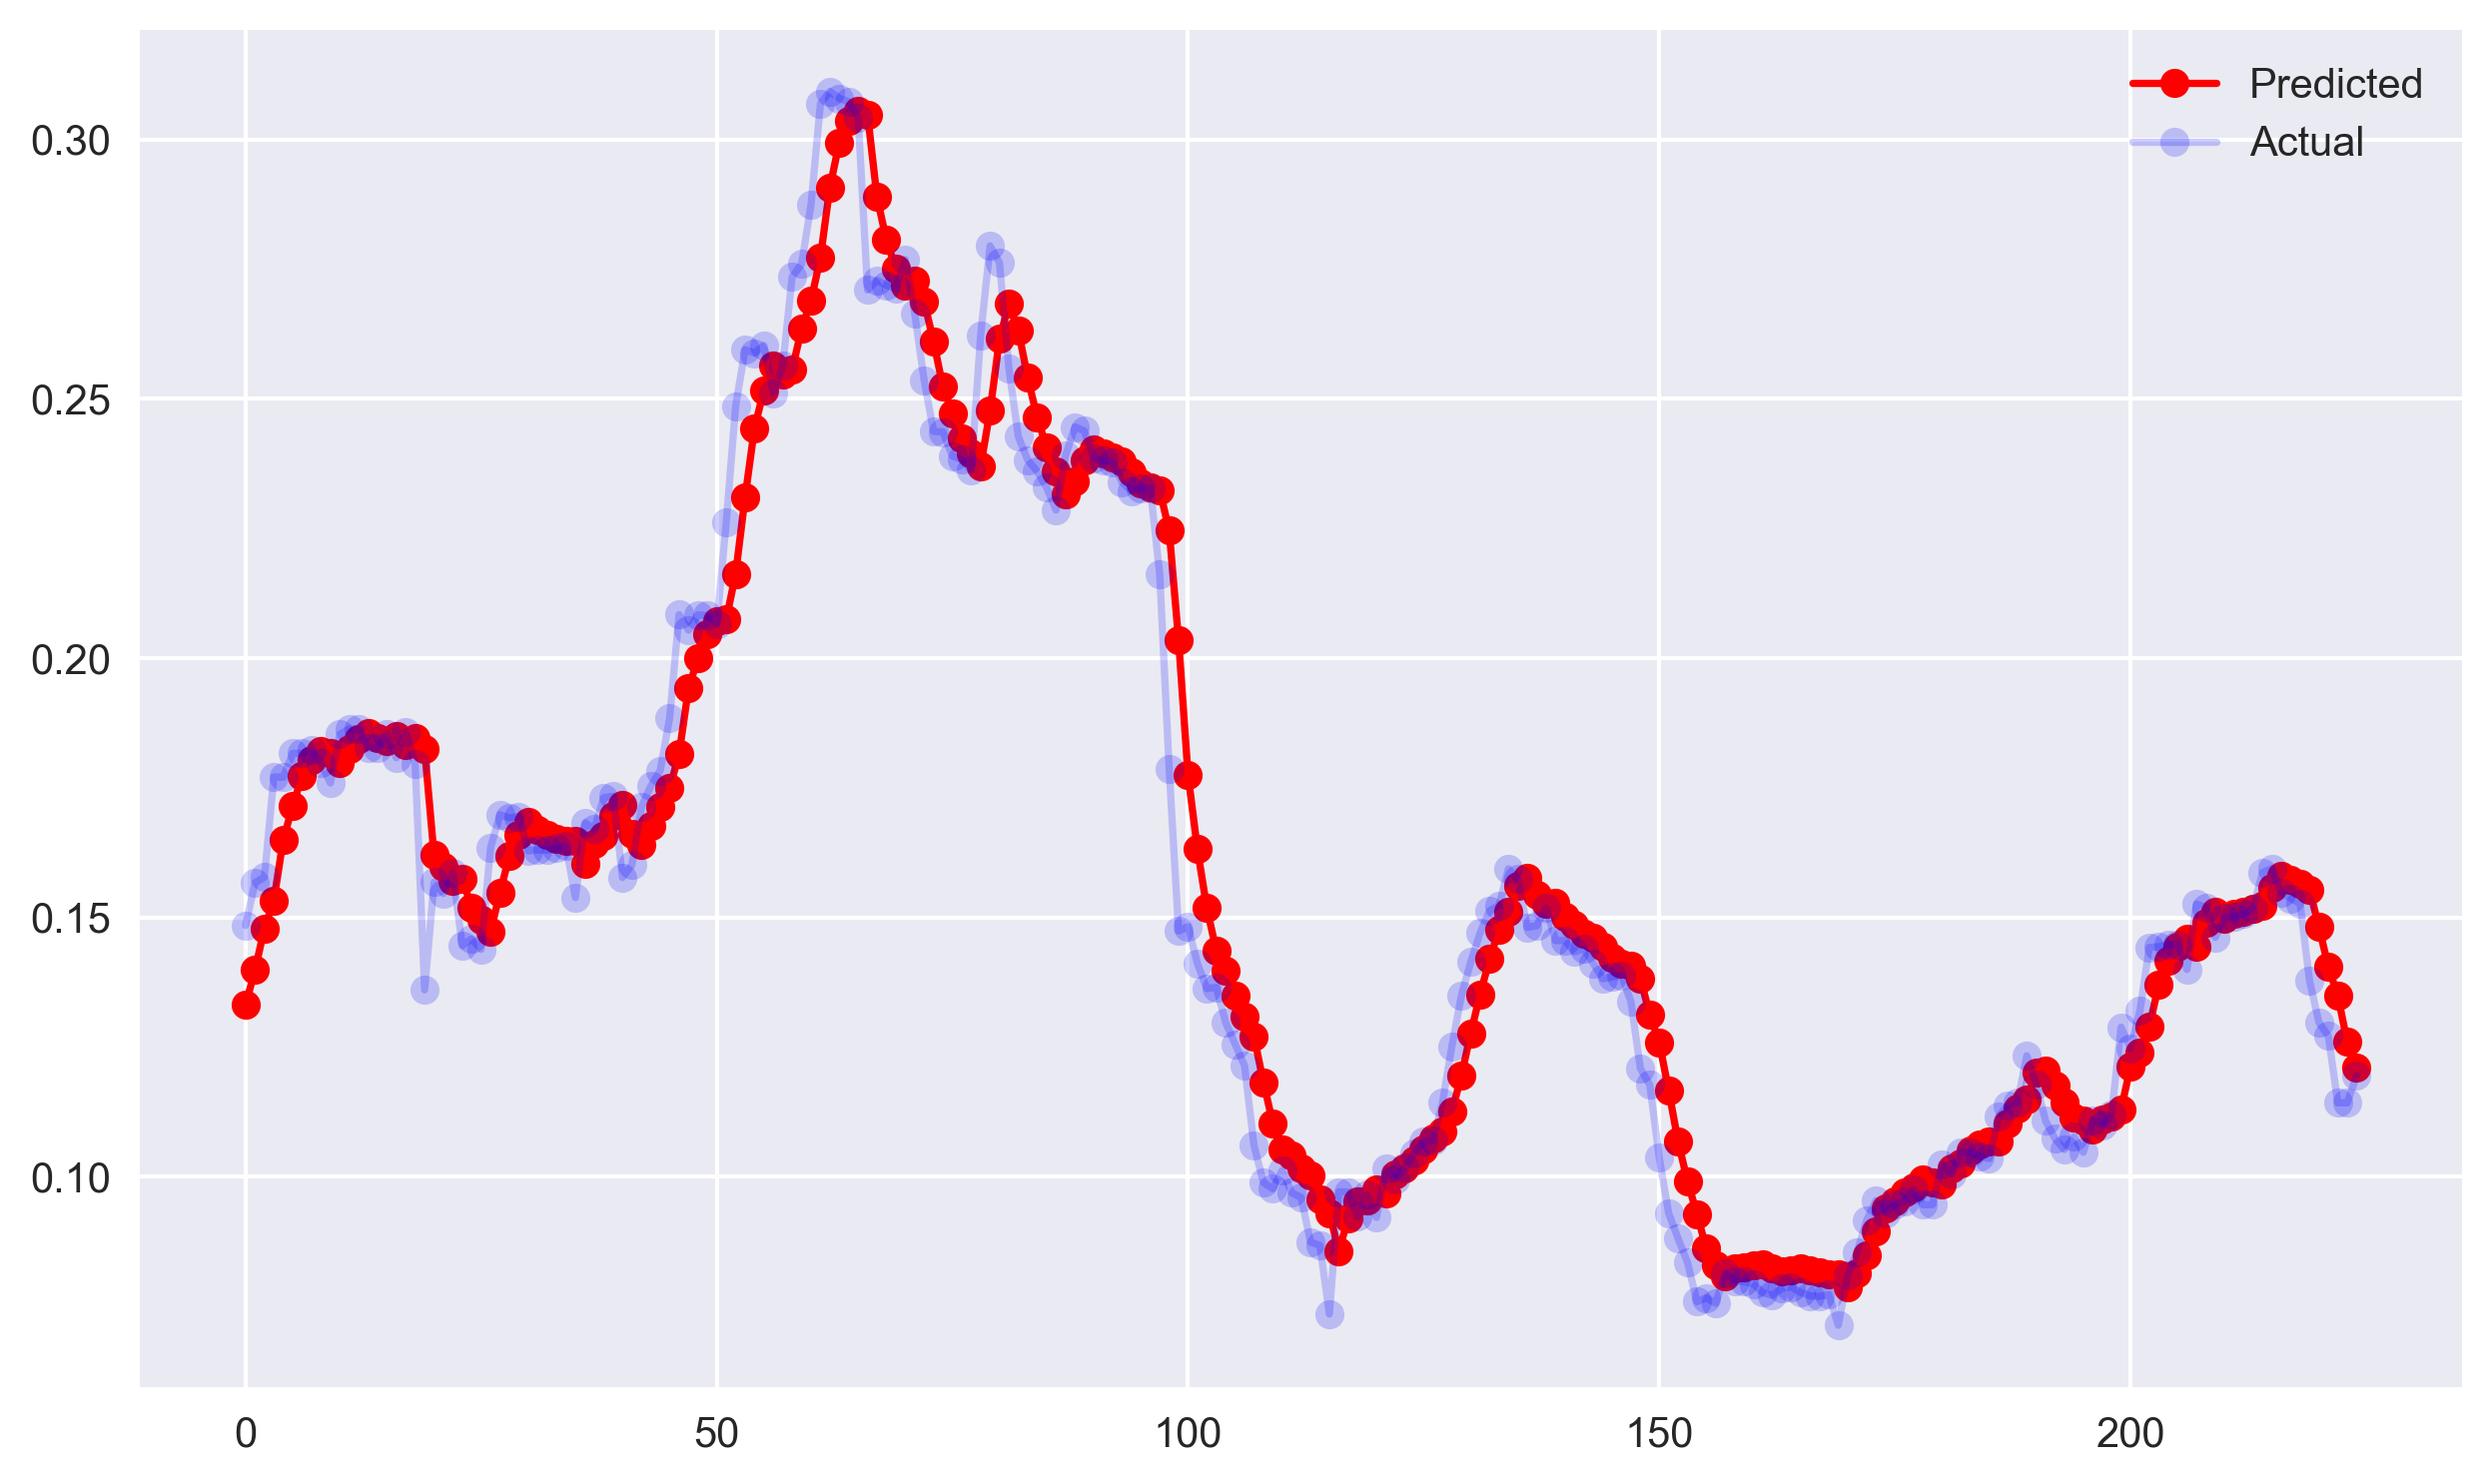

In [19]:
y_hat = []
for i, j in zip(models, X_test):
    y_hat.append(i.predict(j, batch_size=1))

for i, j in zip(y_hat, y_test):
    a_axis = np.arange(0, i.shape[0])
    b_axis = np.arange(0, j.shape[0])
    plt.figure(figsize=(10,6))
    plt.plot(b_axis, i.reshape(i.shape[0],), 'o-', color='red', label='Predicted')
    plt.plot(b_axis, j.reshape(j.shape[0],), 'o-', color='blue', alpha=0.2, label='Actual')
    plt.legend()
    plt.show()

In [20]:
for i in histories:
    print(np.mean(np.sqrt(i.history['val_loss'])))

51.38896354495627
0.5396733349042195
0.015379247987806582
